In [51]:
pip install pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Step 1 본 설정 & 유틸 (경로 고정, 공통 함수)

In [52]:
# -*- coding: utf-8 -*-
# STEP 1: 기본 설정 & 유틸 (경로 자동 감지: 'F1 data' 우선)

import pandas as pd
import numpy as np
from pathlib import Path
from typing import List
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, classification_report

# ====== 경로 자동 감지 ======
BASE = Path.home() / "Desktop" / "F1_Prediction_Project"

# 필수 CSV 목록
_REQUIRED = [
    "races.csv","qualifying.csv","results.csv","constructor_results.csv","status.csv",
    "driver_standings.csv","constructor_standings.csv","pit_stops.csv","lap_times.csv",
    "sprint_results.csv","circuits.csv","constructors.csv","drivers.csv","seasons.csv"
]

# 후보 데이터 폴더들: 루트 또는 하위의 'F1 data' 등 흔한 표기
_candidates = [
    BASE,
    BASE / "F1 data",
    BASE / "F1_data",
    BASE / "F1-data",
]

def _score_dir(d: Path) -> int:
    """폴더 안에 필수 CSV가 몇 개 존재하는지 점수화"""
    return sum((d / name).exists() for name in _REQUIRED)

# 가장 많은 CSV를 가진 폴더를 DATA_DIR로 선택
DATA_DIR = max(_candidates, key=_score_dir)

print(f"[STEP 1] BASE = {BASE}")
print(f"[STEP 1] DATA_DIR(selected) = {DATA_DIR}")

def read_csv(name: str) -> pd.DataFrame:
    """선택된 DATA_DIR에서 CSV를 읽습니다."""
    return pd.read_csv(DATA_DIR / name, low_memory=False)

# ====== 유틸 함수들 ======
def time_to_ms(s: pd.Series) -> pd.Series:
    """'m:ss.sss' 또는 'ss.sss' 문자열을 밀리초(float)로 변환"""
    def parse(x):
        if pd.isna(x): return np.nan
        st = str(x).strip()
        if st == "" or st.lower() == "nan": return np.nan
        try:
            if ":" in st:  # 'm:ss.sss'
                m, sec = st.split(":")
                return (int(m)*60 + float(sec))*1000.0
            return float(st)*1000.0      # 'ss.sss'
        except:
            return np.nan
    return s.apply(parse)

def build_chronology(races: pd.DataFrame) -> pd.DataFrame:
    """연-라운드 기준으로 정렬된 race_order(시간축) 생성"""
    rx = races[["raceId","year","round","circuitId"]].copy()
    rx["year_round"] = rx["year"].astype(int)*100 + rx["round"].astype(int)
    rx = rx.sort_values(["year","round"]).reset_index(drop=True)
    rx["race_order"] = np.arange(len(rx))
    return rx

def map_status_to_dnf(status: pd.DataFrame) -> set:
    """DNF/리타이어 성격 statusId 집합 생성"""
    pats = ["DNF","Accident","Engine","Gearbox","Hydraulics","Clutch","Brakes","Electrical",
            "Collision","Suspension","Power","Overheating","Tyre","Exhaust","Driveshaft",
            "Fuel","Transmission","Wheel","Oil","Water","Turbo","Differential",
            "Withdrawn","Did not start"]
    pat = "|".join(pats)
    return set(status[status["status"].str.contains(pat, case=False, na=False)]["statusId"].tolist())

def add_prev_snapshot(df: pd.DataFrame, group_cols: List[str], order_col: str, cols: List[str], suffix="_prev") -> pd.DataFrame:
    """그룹별로 한 경기 이전 값(직전 스냅샷)으로 시프트"""
    df = df.sort_values(group_cols + [order_col]).copy()
    for c in cols:
        df[c + suffix] = df.groupby(group_cols)[c].shift(1)
    return df

def rolling_by_past(df: pd.DataFrame, entity_col: str, order_col: str, value_cols: List[str],
                    windows=(3,5,10), agg="mean", prefix="drv"):
    """
    과거 경기만 반영하는(shift 포함) 롤링 집계.
    - entity_col: group 기준 (driverId / constructorId)
    - order_col : 시간 순서 (race_order)
    - value_cols: 집계 대상 컬럼 (points, position, is_dnf 등)
    - windows   : 롤링 창 크기 (3/5/10 경기)
    - agg       : 'mean'|'median'|'std'|'sum'
    """
    out = df.sort_values([entity_col, order_col]).copy()
    for v in value_cols:
        for w in windows:
            key = f"{prefix}_{v}_{agg}_{w}"
            if agg == "mean":
                out[key] = out.groupby(entity_col)[v].rolling(w, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)
            elif agg == "median":
                out[key] = out.groupby(entity_col)[v].rolling(w, min_periods=1).median().reset_index(level=0, drop=True).shift(1)
            elif agg == "std":
                out[key] = out.groupby(entity_col)[v].rolling(w, min_periods=1).std().reset_index(level=0, drop=True).shift(1)
            elif agg == "sum":
                out[key] = out.groupby(entity_col)[v].rolling(w, min_periods=1).sum().reset_index(level=0, drop=True).shift(1)
            else:
                raise ValueError("Unsupported agg")
    return out

print("STEP 1 OK")

[STEP 1] BASE = /Users/minseobeom/Desktop/F1_Prediction_Project
[STEP 1] DATA_DIR(selected) = /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data
STEP 1 OK


In [53]:
print("📂 CSV 존재 점검:")
for nm in _REQUIRED:
    print(f"{nm:<25} -> {(DATA_DIR/nm).exists()}")

📂 CSV 존재 점검:
races.csv                 -> True
qualifying.csv            -> True
results.csv               -> True
constructor_results.csv   -> True
status.csv                -> True
driver_standings.csv      -> True
constructor_standings.csv -> True
pit_stops.csv             -> True
lap_times.csv             -> True
sprint_results.csv        -> True
circuits.csv              -> True
constructors.csv          -> True
drivers.csv               -> True
seasons.csv               -> True


## STEP 2 — CSV 로드

In [54]:
# STEP 2: CSV 로드
races = read_csv("races.csv")
circuits = read_csv("circuits.csv")
qualifying = read_csv("qualifying.csv")
results = read_csv("results.csv")
constructor_results = read_csv("constructor_results.csv")
driver_standings = read_csv("driver_standings.csv")
constructor_standings = read_csv("constructor_standings.csv")
pit_stops = read_csv("pit_stops.csv")
lap_times = read_csv("lap_times.csv")
status = read_csv("status.csv")
sprint_results = read_csv("sprint_results.csv")

# 간단 무결성 체크: 주요 컬럼 존재 여부
required_cols = {
    "races": ["raceId","year","round","circuitId"],
    "qualifying": ["raceId","driverId","constructorId","grid"],
    "results": ["raceId","driverId","constructorId","points","position","statusId","grid"],
    "constructor_results": ["raceId","constructorId","points"],
    "driver_standings": ["raceId","driverId","points","position"],
    "constructor_standings": ["raceId","constructorId","points","position"],
    "pit_stops": ["raceId","driverId","constructorId","milliseconds"],
    "lap_times": ["raceId","driverId","constructorId","milliseconds"],
    "status": ["statusId","status"],
    "circuits": ["circuitId"],
    "sprint_results": ["raceId","driverId","constructorId","grid","position","points"],
}

dfs = {
    "races": races, "circuits": circuits, "qualifying": qualifying, "results": results,
    "constructor_results": constructor_results, "driver_standings": driver_standings,
    "constructor_standings": constructor_standings, "pit_stops": pit_stops,
    "lap_times": lap_times, "status": status, "sprint_results": sprint_results
}

# 행 수 요약
print("STEP 2 OK | rows:", {name: len(df) for name, df in dfs.items()})

# 필수 컬럼이 빠졌는지 간단 확인(없으면 이름을 출력)
for name, cols in required_cols.items():
    missing = [c for c in cols if c not in dfs[name].columns]
    if missing:
        print(f"[WARN] {name} missing columns: {missing}")

STEP 2 OK | rows: {'races': 1125, 'circuits': 77, 'qualifying': 10494, 'results': 26759, 'constructor_results': 12625, 'driver_standings': 34863, 'constructor_standings': 13391, 'pit_stops': 11371, 'lap_times': 589081, 'status': 139, 'sprint_results': 360}
[WARN] qualifying missing columns: ['grid']
[WARN] pit_stops missing columns: ['constructorId']
[WARN] lap_times missing columns: ['constructorId']


## STEP 3 — 시간축, 라벨(y), 예선 피처 (+ 매핑 준비)

In [55]:
# STEP 3: 시간축(race_order), 라벨(y_top10), 예선 피처(qualifying) + 매핑 준비

# 1) 시간축(연-라운드 순서 인덱스)
rx = build_chronology(races)              # race_order 생성

# 2) DNF 매핑 집합
dnf_ids = map_status_to_dnf(status)       # statusId -> DNF 여부 집합

# 3) 예선(사전 피처)
#    - qualifying에는 'grid'가 없는 스키마가 일반적임 → grid는 results에서 사용
q = qualifying.copy()

# Q1/Q2/Q3 문자열을 ms로 변환 (없으면 알아서 NaN으로 남습니다)
for c in ["q1","q2","q3"]:
    if c in q.columns:
        q[c + "_ms"] = time_to_ms(q[c])

# 예선 순위 -> quali_position (명시적 이름)
if "position" in q.columns:
    q = q.rename(columns={"position":"quali_position"})
else:
    q["quali_position"] = np.nan  # 컬럼이 없더라도 파이프라인이 깨지지 않게

# 예선 피처 최소 집합(중복 제거)
keep_q_cols = ["raceId","driverId","constructorId","quali_position","q1_ms","q2_ms","q3_ms"]
keep_q_cols = [c for c in keep_q_cols if c in q.columns]  # 실제 존재하는 컬럼만
q = q[keep_q_cols].drop_duplicates(subset=["raceId","driverId"], keep="last")

# 4) 라벨/기본 베이스 (결승 결과에서 y, grid까지 확보)
#    - grid(스타팅 그리드)는 results에 있으므로 여기서 사용
base_cols_res = ["raceId","driverId","constructorId","grid","position","points","statusId"]
base_cols_res = [c for c in base_cols_res if c in results.columns]
res = results[base_cols_res].copy()

# DNF 여부, y_top10 생성
if "statusId" in res.columns:
    res["is_dnf"] = res["statusId"].isin(dnf_ids).astype(int)
else:
    res["is_dnf"] = np.nan
res["y_top10"] = (res["points"] > 0).astype(int)

# 시간축 머지
res = res.merge(rx[["raceId","year","round","race_order"]], on="raceId", how="left")

# 5) (raceId, driverId) -> constructorId 매핑 준비
#    - pit_stops, lap_times에 constructorId가 없는 경우 나중 스텝에서 이 매핑으로 보완
cid_map = results[["raceId","driverId","constructorId"]].drop_duplicates()
print("STEP 3 OK")
print(" - q shape:", q.shape, "| cols:", list(q.columns))
print(" - res shape:", res.shape, "| cols:", list(res.columns))
print(" - cid_map rows:", len(cid_map))

STEP 3 OK
 - q shape: (10494, 7) | cols: ['raceId', 'driverId', 'constructorId', 'quali_position', 'q1_ms', 'q2_ms', 'q3_ms']
 - res shape: (26759, 12) | cols: ['raceId', 'driverId', 'constructorId', 'grid', 'position', 'points', 'statusId', 'is_dnf', 'y_top10', 'year', 'round', 'race_order']
 - cid_map rows: 26685


In [56]:
# STEP 3.5: 데이터 타입 정리(문자열 "\N" -> NaN, 숫자형 캐스팅)

# 1) results 기반 피처에 꼭 필요한 컬럼들에서 "\N"을 NaN으로 바꾸고 숫자로 캐스팅
for col in ["points", "position", "grid", "statusId", "year", "round", "race_order"]:
    if col in res.columns:
        res[col] = pd.to_numeric(res[col].replace({"\\N": np.nan}), errors="coerce")

# 2) 예선 피처에서 혹시 남아 있을 수 있는 비숫자 문자열 정리 (이미 ms 변환했지만 안전망)
for c in ["quali_position", "q1_ms", "q2_ms", "q3_ms"]:
    if c in q.columns:
        q[c] = pd.to_numeric(q[c].replace({"\\N": np.nan}), errors="coerce")

# 3) sanity check
print("STEP 3.5 OK | dtypes (res):", res[["points","position","grid","race_order"]].dtypes.to_dict())

STEP 3.5 OK | dtypes (res): {'points': dtype('float64'), 'position': dtype('float64'), 'grid': dtype('int64'), 'race_order': dtype('int64')}


## STEP 4 — 드라이버 롤링 피처(3/5/10)

In [57]:
# STEP 4: 드라이버 롤링(최근 3/5/10전) 피처
# 대상: points(평균), position(중앙값), DNF율(평균)
# 기준: driverId별 시간순(race_order)로 과거만 보도록 shift 포함

# points 평균 (폼)
drv_roll_mean = rolling_by_past(
    res, entity_col="driverId", order_col="race_order",
    value_cols=["points"], windows=(3,5,10), agg="mean", prefix="drv"
)

# position 중앙값 (순위 안정성)
drv_roll_med  = rolling_by_past(
    res, entity_col="driverId", order_col="race_order",
    value_cols=["position"], windows=(3,5,10), agg="median", prefix="drv"
)

# DNF율 (신뢰성)
drv_roll_dnf  = rolling_by_past(
    res.assign(is_dnf=res["is_dnf"].astype(float)),
    entity_col="driverId", order_col="race_order",
    value_cols=["is_dnf"], windows=(3,5,10), agg="mean", prefix="drv"
)

# 피처 테이블 조립 (raceId, driverId, constructorId 키 유지)
drv_feats = res[["raceId","driverId","constructorId"]].copy()

cols_mean = [c for c in drv_roll_mean.columns if c.startswith("drv_points_mean_")]
cols_med  = [c for c in drv_roll_med.columns  if c.startswith("drv_position_median_")]
cols_dnf  = [c for c in drv_roll_dnf.columns  if c.startswith("drv_is_dnf_mean_")]

drv_feats = (drv_feats
    .merge(drv_roll_mean[["raceId","driverId"] + cols_mean], on=["raceId","driverId"], how="left")
    .merge(drv_roll_med[["raceId","driverId"] + cols_med],   on=["raceId","driverId"], how="left")
    .merge(drv_roll_dnf[["raceId","driverId"] + cols_dnf],   on=["raceId","driverId"], how="left")
)

print("STEP 4 OK")
print(" - drv_feats shape:", drv_feats.shape)
print(" - sample cols:", cols_mean[:2] + cols_med[:2] + cols_dnf[:2])

STEP 4 OK
 - drv_feats shape: (28333, 12)
 - sample cols: ['drv_points_mean_3', 'drv_points_mean_5', 'drv_position_median_3', 'drv_position_median_5', 'drv_is_dnf_mean_3', 'drv_is_dnf_mean_5']


## STEP 5 (팀 폼: 컨스트럭터 최근 3/5/10전 평균 득점)

In [58]:
# STEP 5: 팀 롤링(최근 3/5/10전) 피처
# 목표: constructor_results 기반으로 팀 폼(최근 N전 평균 득점)을 만들고 race_order에 맞춰 과거만 보도록 shift 포함

# 0) 타입 정리: constructor_results.points에 "\N" 등 문자열이 있을 수 있어 숫자형으로 캐스팅
cr = constructor_results.copy()
if "points" in cr.columns:
    cr["points"] = pd.to_numeric(cr["points"].replace({"\\N": np.nan}), errors="coerce")

# 1) race_order 부여
cr = cr.merge(rx[["raceId","race_order"]], on="raceId", how="left")

# 2) 팀 롤링: constructorId 기준으로 points 평균의 3/5/10 경기 창
cr_roll = rolling_by_past(
    cr, entity_col="constructorId", order_col="race_order",
    value_cols=["points"], windows=(3,5,10), agg="mean", prefix="team"
)

# 3) 팀 피처 테이블 (raceId, constructorId 키 유지)
team_cols = [c for c in cr_roll.columns if c.startswith("team_points_mean_")]
team_feats = cr_roll[["raceId","constructorId"] + team_cols].copy()

print("STEP 5 OK")
print(" - team_feats shape:", team_feats.shape)
print(" - sample cols:", team_cols[:3])

STEP 5 OK
 - team_feats shape: (12625, 5)
 - sample cols: ['team_points_mean_3', 'team_points_mean_5', 'team_points_mean_10']


## STEP 6 (스탠딩 ‘직전’ 스냅샷)

In [59]:
# STEP 6: standings '직전' 스냅샷(prev) 만들기
# 목표: driver/constructor_standings를 race_order에 맞춰 한 칸 밀어(shift)
#       "직전 라운드까지의 누적 포인트/순위" 피처 생성

# 0) 타입 정리: "\N" 등 문자열을 NaN으로 치환 후 숫자형으로
ds = driver_standings.copy()
for col in ["points","position"]:
    if col in ds.columns:
        ds[col] = pd.to_numeric(ds[col].replace({"\\N": np.nan}), errors="coerce")
ds = ds.merge(rx[["raceId","race_order"]], on="raceId", how="left")

cs = constructor_standings.copy()
for col in ["points","position"]:
    if col in cs.columns:
        cs[col] = pd.to_numeric(cs[col].replace({"\\N": np.nan}), errors="coerce")
cs = cs.merge(rx[["raceId","race_order"]], on="raceId", how="left")

# 1) 드라이버 직전 스냅샷: 그룹=driverId, 정렬=race_order, 대상=points/position
ds_prev = add_prev_snapshot(
    ds, group_cols=["driverId"], order_col="race_order",
    cols=["points","position"]
)[["raceId","driverId","points_prev","position_prev"]]

# 2) 팀(컨스트럭터) 직전 스냅샷: 그룹=constructorId
cs_prev = add_prev_snapshot(
    cs, group_cols=["constructorId"], order_col="race_order",
    cols=["points","position"]
)[["raceId","constructorId","points_prev","position_prev"]] \
   .rename(columns={"points_prev":"team_points_prev",
                    "position_prev":"team_position_prev"})

print("STEP 6 OK")
print(" - ds_prev shape:", ds_prev.shape, "| cols:", list(ds_prev.columns))
print(" - cs_prev shape:", cs_prev.shape, "| cols:", list(cs_prev.columns))

STEP 6 OK
 - ds_prev shape: (34863, 4) | cols: ['raceId', 'driverId', 'points_prev', 'position_prev']
 - cs_prev shape: (13391, 4) | cols: ['raceId', 'constructorId', 'team_points_prev', 'team_position_prev']


## STEP 7 (피트/랩 과거 집계 + 스프린트 피처)

In [60]:
# STEP 7: 피트/랩 과거 집계 + 스프린트 피처
# 목표
#  - pit_stops: 레이스별 평균/표준편차 → 드라이버 기준 과거 3/5/10전 롤링
#  - lap_times: 레이스별 best/median/var → 드라이버 기준 과거 3/5/10전 롤링
#  - sprint_results: 같은 주말 사전 신호(그리드/포인트/포지션)

# ========= PIT STOPS =========
ps = pit_stops.copy()

# 0) 타입 정리
if "milliseconds" in ps.columns:
    ps["milliseconds"] = pd.to_numeric(ps["milliseconds"].replace({"\\N": np.nan}), errors="coerce")

# 1) 시간축(race_order) 부여
ps = ps.merge(rx[["raceId","race_order"]], on="raceId", how="left")

# 2) 레이스별 집계(드라이버 단위)
#    constructorId가 없을 수 있으므로 이후 cid_map으로 보완
ps_race = (ps.groupby(["raceId","driverId","race_order"])["milliseconds"]
             .agg(["mean","std"]).reset_index())

# 3) constructorId 보완: (raceId, driverId) -> constructorId 매핑
ps_race = ps_race.merge(cid_map, on=["raceId","driverId"], how="left")

# 4) 롤링(과거만 보도록 shift 포함)
ps_race = ps_race.sort_values(["driverId","race_order"])
for w in [3,5,10]:
    ps_race[f"drv_pit_ms_mean_{w}"] = (ps_race.groupby("driverId")["mean"]
                                       .rolling(w, min_periods=1).mean()
                                       .reset_index(level=0, drop=True).shift(1))
    ps_race[f"drv_pit_ms_std_{w}"]  = (ps_race.groupby("driverId")["std"]
                                       .rolling(w, min_periods=1).mean()
                                       .reset_index(level=0, drop=True).shift(1))

pit_feat_cols = [c for c in ps_race.columns if c.startswith("drv_pit_ms_")]
pit_feats = ps_race[["raceId","driverId","constructorId"] + pit_feat_cols].copy()

# ========= LAP TIMES =========
lt = lap_times.copy()

# 0) 타입 정리
if "milliseconds" in lt.columns:
    lt["milliseconds"] = pd.to_numeric(lt["milliseconds"].replace({"\\N": np.nan}), errors="coerce")

# 1) 시간축 부여
lt = lt.merge(rx[["raceId","race_order"]], on="raceId", how="left")

# 2) 레이스별 집계(드라이버 단위): best/min, median, variance
lt_race = (lt.groupby(["raceId","driverId","race_order"])["milliseconds"]
             .agg(best="min", med="median", var="var").reset_index())

# 3) constructorId 보완
lt_race = lt_race.merge(cid_map, on=["raceId","driverId"], how="left")

# 4) 롤링(과거만)
lt_race = lt_race.sort_values(["driverId","race_order"])
for w in [3,5,10]:
    lt_race[f"drv_bestlap_ms_mean_{w}"] = (lt_race.groupby("driverId")["best"]
                                           .rolling(w, min_periods=1).mean()
                                           .reset_index(level=0, drop=True).shift(1))
    lt_race[f"drv_lap_med_ms_mean_{w}"] = (lt_race.groupby("driverId")["med"]
                                           .rolling(w, min_periods=1).mean()
                                           .reset_index(level=0, drop=True).shift(1))
    lt_race[f"drv_lap_var_mean_{w}"]    = (lt_race.groupby("driverId")["var"]
                                           .rolling(w, min_periods=1).mean()
                                           .reset_index(level=0, drop=True).shift(1))

lap_feat_cols = [c for c in lt_race.columns if c.startswith("drv_") and "_mean_" in c]
lap_feats = lt_race[["raceId","driverId","constructorId"] + lap_feat_cols].copy()

# ========= SPRINT FEATURES =========
if not sprint_results.empty:
    sr = sprint_results.copy()
    for c in ["grid","position","points","statusId"]:
        if c in sr.columns:
            sr[c] = pd.to_numeric(sr[c].replace({"\\N": np.nan}), errors="coerce")
    sr = sr.rename(columns={
        "grid":"sprint_grid",
        "position":"sprint_pos",
        "points":"sprint_pts",
        "statusId":"sprint_statusId"
    })
    sprint_feats = sr[["raceId","driverId","constructorId","sprint_grid","sprint_pos","sprint_pts","sprint_statusId"]].drop_duplicates(
        subset=["raceId","driverId"], keep="last"
    )
else:
    sprint_feats = pd.DataFrame(columns=["raceId","driverId","constructorId","sprint_grid","sprint_pos","sprint_pts","sprint_statusId"])

print("STEP 7 OK")
print(" - pit_feats:", pit_feats.shape, "| cols(ex):", pit_feat_cols[:3])
print(" - lap_feats:", lap_feats.shape, "| cols(ex):", lap_feat_cols[:3])
print(" - sprint_feats:", sprint_feats.shape)

STEP 7 OK
 - pit_feats: (5575, 9) | cols(ex): ['drv_pit_ms_mean_3', 'drv_pit_ms_std_3', 'drv_pit_ms_mean_5']
 - lap_feats: (11041, 12) | cols(ex): ['drv_bestlap_ms_mean_3', 'drv_lap_med_ms_mean_3', 'drv_lap_var_mean_3']
 - sprint_feats: (360, 7)


## STEP 8 (피처 조립 → 학습/검증 → 산출물 저장)

In [61]:
# STEP 8: 피처 조립 → 학습/검증 → 산출물 저장

# 1) 피처 조립 (키: raceId, driverId, constructorId)
feat = (res
    .merge(q,           on=["raceId","driverId","constructorId"], how="left")
    .merge(drv_feats,   on=["raceId","driverId","constructorId"], how="left")
    .merge(team_feats,  on=["raceId","constructorId"],            how="left")
    .merge(ds_prev,     on=["raceId","driverId"],                 how="left")
    .merge(cs_prev,     on=["raceId","constructorId"],            how="left")
    .merge(pit_feats,   on=["raceId","driverId","constructorId"], how="left")
    .merge(lap_feats,   on=["raceId","driverId","constructorId"], how="left")
    .merge(sprint_feats,on=["raceId","driverId","constructorId"], how="left")
    .merge(rx[["raceId","year","round","circuitId","race_order"]], on="raceId", how="left")
    .merge(circuits[["circuitId","name"]].rename(columns={"name":"circuit_name"}), on="circuitId", how="left")
)

# 2) 모델 입력 컬럼 정의 (존재 여부로 필터링하여 안전하게)
y_col = "y_top10"
group_col = "raceId"

base_cols = [
    "grid",                 # results에서 온 그리드 (사전 정보)
    "quali_position",       # 예선 순위
    "q1_ms","q2_ms","q3_ms",
    "team_points_prev","team_position_prev",  # 팀 직전 스냅샷
    "points_prev","position_prev",            # 드라이버 직전 스냅샷
    "sprint_grid","sprint_pos","sprint_pts"   # 스프린트 사전 신호(있을 때)
]

drv_roll_cols = [c for c in feat.columns if c.startswith("drv_points_mean_") or
                                           c.startswith("drv_position_median_") or
                                           c.startswith("drv_is_dnf_mean_")]
team_roll_cols = [c for c in feat.columns if c.startswith("team_points_mean_")]
pit_cols       = [c for c in feat.columns if c.startswith("drv_pit_ms_")]
lap_cols       = [c for c in feat.columns if c.startswith("drv_bestlap_ms_mean_") or
                                            c.startswith("drv_lap_med_ms_mean_")  or
                                            c.startswith("drv_lap_var_mean_")]

model_cols = [c for c in (base_cols + drv_roll_cols + team_roll_cols + pit_cols + lap_cols) if c in feat.columns]

# (PATCH) 'year'가 없으면 races에서 다시 가져와 보강
if "year" not in feat.columns:
    feat = feat.merge(races[["raceId","year"]], on="raceId", how="left")
    print("[PATCH] 'year' added from races.csv")

# (다음 줄은 기존 STEP 8 코드와 동일)
model_cols = [c for c in (base_cols + drv_roll_cols + team_roll_cols + pit_cols + lap_cols) if c in feat.columns]

# 3) 데이터셋 구축 + 숫자형 캐스팅/결측 처리
model_df = feat[model_cols + [y_col, group_col, "year"]].dropna(subset=[y_col]).copy()

# 3) 데이터셋 구축 + 숫자형 캐스팅/결측 처리
model_df = feat[model_cols + [y_col, group_col, "year"]].dropna(subset=[y_col]).copy()

# 숫자형으로 강제 캐스팅 (문자열 "\N" 등 대비)
for c in model_cols:
    model_df[c] = pd.to_numeric(model_df[c], errors="coerce")

# 간단한 결측 처리: 앞선 값 채우기 후 0 (초기 라운드/미진행 예선 등)
X = model_df[model_cols].fillna(method="ffill").fillna(0.0)
y = model_df[y_col].astype(int)
groups = model_df[group_col]

# 4) 모델·검증 설정 (GroupKFold by raceId → 같은 레이스가 train/val에 섞이지 않도록)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, classification_report

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear"))
])

print(f"[MODEL] n_features={X.shape[1]} | n_samples={X.shape[0]}")

from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)
oof_pred = np.zeros(len(y), dtype=int)
oof_prob = np.zeros(len(y), dtype=float)

for fold, (tr, va) in enumerate(gkf.split(X, y, groups=groups), 1):
    pipe.fit(X.iloc[tr], y.iloc[tr])
    prob = pipe.predict_proba(X.iloc[va])[:, 1]
    pred = (prob >= 0.5).astype(int)
    oof_prob[va] = prob
    oof_pred[va] = pred
    f1 = f1_score(y.iloc[va], pred, average="macro")
    ap = average_precision_score(y.iloc[va], prob)
    print(f"[Fold {fold}] Macro-F1={f1:.4f} | PR-AUC(AP)={ap:.4f}")

macro_f1 = f1_score(y, oof_pred, average="macro")
ap_all   = average_precision_score(y, oof_prob)
print(f"[OOF] Macro-F1={macro_f1:.4f} | PR-AUC(AP)={ap_all:.4f}")
print(classification_report(y, oof_pred, digits=3))

# 5) (선택) 2024 홀드아웃 평가
if (model_df["year"] == 2024).any():
    tr_idx = model_df["year"] < 2024
    te_idx = model_df["year"] == 2024
    pipe.fit(X[tr_idx], y[tr_idx])
    prob_te = pipe.predict_proba(X[te_idx])[:, 1]
    pred_te = (prob_te >= 0.5).astype(int)

    from sklearn.metrics import f1_score, average_precision_score
    f1_te = f1_score(y[te_idx], pred_te, average="macro")
    ap_te = average_precision_score(y[te_idx], prob_te)
    print(f"[2024 Holdout] Macro-F1={f1_te:.4f} | PR-AUC(AP)={ap_te:.4f}")

    # 레이스별 결과 저장
    (model_df.loc[te_idx, ["raceId","year"]]
        .assign(y=y[te_idx].values, prob=prob_te, pred=pred_te)
        .to_csv(DATA_DIR / "f1_holdout_2024_predictions.csv", index=False))
    print("Saved:", DATA_DIR / "f1_holdout_2024_predictions.csv")

# 6) 피처 미리보기 저장 (상위 2000행, 컬럼 일부만)
preview_cols = ["year","raceId",y_col] + model_cols[:30]
(model_df[preview_cols].head(2000)
         .to_csv(DATA_DIR / "f1_enhanced_feature_preview.csv", index=False))
print("Saved:", DATA_DIR / "f1_enhanced_feature_preview.csv")

print("STEP 8 OK")

[PATCH] 'year' added from races.csv
[MODEL] n_features=39 | n_samples=29983


/var/folders/yl/3cpbqsq96s70dm9lcf8p9c_00000gn/T/ipykernel_33755/2697639665.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = model_df[model_cols].fillna(method="ffill").fillna(0.0)


[Fold 1] Macro-F1=0.7536 | PR-AUC(AP)=0.6993
[Fold 2] Macro-F1=0.7369 | PR-AUC(AP)=0.6848
[Fold 3] Macro-F1=0.7362 | PR-AUC(AP)=0.7041
[Fold 4] Macro-F1=0.7019 | PR-AUC(AP)=0.6545
[Fold 5] Macro-F1=0.7165 | PR-AUC(AP)=0.6566
[OOF] Macro-F1=0.7290 | PR-AUC(AP)=0.6784
              precision    recall  f1-score   support

           0      0.879     0.757     0.813     21129
           1      0.564     0.751     0.645      8854

    accuracy                          0.755     29983
   macro avg      0.722     0.754     0.729     29983
weighted avg      0.786     0.755     0.764     29983

[2024 Holdout] Macro-F1=0.7940 | PR-AUC(AP)=0.8620
Saved: /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/f1_holdout_2024_predictions.csv
Saved: /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/f1_enhanced_feature_preview.csv
STEP 8 OK


## Step 9 (임계값 튜닝 + 혼동행렬)

In [62]:
# STEP 9: 임계값 튜닝 (Macro-F1 최대화) + 혼동행렬, 2024 재평가
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report, average_precision_score

# 1) OOF 확률 기반으로 최적 임계값 탐색
ths = np.linspace(0.2, 0.8, 61)  # 0.2~0.8 사이 0.01 간격
best_th, best_f1 = 0.5, -1
for th in ths:
    pred_tmp = (oof_prob >= th).astype(int)
    f1 = f1_score(y, pred_tmp, average="macro")
    if f1 > best_f1:
        best_f1, best_th = f1, th

print(f"[THRESHOLD] best_th={best_th:.3f} | OOF Macro-F1={best_f1:.4f}")

# 2) 최적 임계값에서 OOF 리포트/혼동행렬
oof_pred_opt = (oof_prob >= best_th).astype(int)
cm = confusion_matrix(y, oof_pred_opt, labels=[0,1])
print("[OOF @best_th] confusion matrix (rows=true, cols=pred):\n", cm)
print(classification_report(y, oof_pred_opt, digits=3))
print("[OOF @best_th] PR-AUC(AP):", average_precision_score(y, oof_prob))

# 3) 2024 홀드아웃을 동일 임계값으로 재평가 (있을 때)
if (model_df["year"] == 2024).any():
    tr_idx = model_df["year"] < 2024
    te_idx = model_df["year"] == 2024

    # 재학습
    pipe.fit(X[tr_idx], y[tr_idx])
    prob_te = pipe.predict_proba(X[te_idx])[:, 1]
    pred_te_opt = (prob_te >= best_th).astype(int)

    f1_te_opt = f1_score(y[te_idx], pred_te_opt, average="macro")
    ap_te = average_precision_score(y[te_idx], prob_te)
    print(f"[2024 @best_th] Macro-F1={f1_te_opt:.4f} | PR-AUC(AP)={ap_te:.4f}")

    # 저장(최적 임계값 포함)
    out_te = (model_df.loc[te_idx, ["raceId","year"]]
                .assign(y=y[te_idx].values, prob=prob_te, pred=pred_te_opt, thr=best_th))
    out_te.to_csv(DATA_DIR / "f1_holdout_2024_predictions_thr.csv", index=False)
    print("Saved:", DATA_DIR / "f1_holdout_2024_predictions_thr.csv")

[THRESHOLD] best_th=0.590 | OOF Macro-F1=0.7407
[OOF @best_th] confusion matrix (rows=true, cols=pred):
 [[17543  3586]
 [ 3006  5848]]
              precision    recall  f1-score   support

           0      0.854     0.830     0.842     21129
           1      0.620     0.660     0.640      8854

    accuracy                          0.780     29983
   macro avg      0.737     0.745     0.741     29983
weighted avg      0.785     0.780     0.782     29983

[OOF @best_th] PR-AUC(AP): 0.6784082150401791
[2024 @best_th] Macro-F1=0.8116 | PR-AUC(AP)=0.8620
Saved: /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/f1_holdout_2024_predictions_thr.csv


## Step 10 (간단 중요도—로지스틱 회귀 계수)

In [63]:
# STEP 10: 간단 중요도 (표준화+로지스틱 계수의 절댓값)
import pandas as pd
import numpy as np

# 파이프라인은 STEP 8에서 만든 pipe를 그대로 사용합니다.
pipe.fit(X, y)
clf = pipe.named_steps["clf"]
coef = getattr(clf, "coef_", None)

if coef is not None:
    imp = pd.Series(np.abs(coef[0]), index=X.columns).sort_values(ascending=False)

    # Top-30 출력
    print("[TOP-30 features by |coef|]")
    for k, v in imp.head(30).items():
        print(f"{k:35s} {v:.5f}")

    # CSV 저장
    imp.to_csv(DATA_DIR / "feature_importance_logreg_abscoef.csv", header=["abs_coef"])
    print("Saved:", DATA_DIR / "feature_importance_logreg_abscoef.csv")
else:
    print("LogisticRegression has no coef_ (check solver or multi_class).")

[TOP-30 features by |coef|]
position_prev                       0.56096
grid                                0.48769
drv_bestlap_ms_mean_5               0.43676
team_position_prev                  0.37337
quali_position                      0.31424
drv_points_mean_10                  0.30719
q2_ms                               0.20530
drv_lap_med_ms_mean_5               0.20505
drv_lap_med_ms_mean_10              0.20335
q3_ms                               0.20010
drv_position_median_3               0.19887
drv_points_mean_3                   0.16497
drv_bestlap_ms_mean_10              0.14288
drv_lap_med_ms_mean_3               0.11675
team_points_mean_10                 0.11369
drv_pit_ms_mean_10                  0.10996
points_prev                         0.08347
team_points_mean_5                  0.06269
team_points_prev                    0.05073
drv_position_median_10              0.04993
drv_position_median_5               0.04941
drv_bestlap_ms_mean_3               0.04774
q1_m

#  Formula 1 Race Prediction for top10(2024)

문제 정의(확정)
	
	•	목표 시즌/범위: 2014–2023 데이터를 학습해 2024 시즌의 모든 그랑프리에 대해
	•	예측 대상: 각 레이스 본 경기 직전(Pre-race, Post-Quali) 시점의 드라이버 Top-10 진입 여부(= 포인트 획득)
	•	출력: 드라이버별 Prob(Top-10)(확률) + 임계값 적용한 이진 예측(진입/미진입)
	•	검증: 학습=2014–2023, 홀드아웃=2024 (레이스 단위 GroupKFold로 OOF 검증 + 2024 최종 평가)

## STEP 1 — 셋업(경로/유틸) 리셋

In [64]:
# STEP 1: Setup (path & utils) — Roadmap1 Reset
import numpy as np, pandas as pd
from pathlib import Path
from typing import List

# ---- Path autodetect (F1_Prediction_Project / F1 data) ----
BASE = Path.home() / "Desktop" / "F1_Prediction_Project"
REQUIRED = ["races.csv","qualifying.csv","results.csv","constructor_results.csv","status.csv",
            "driver_standings.csv","constructor_standings.csv","pit_stops.csv","lap_times.csv",
            "sprint_results.csv","circuits.csv","constructors.csv","drivers.csv","seasons.csv"]
CANDS = [BASE, BASE/"F1 data", BASE/"F1_data", BASE/"F1-data"]
DATA_DIR = max(CANDS, key=lambda d: sum((d/f).exists() for f in REQUIRED))

def read_csv(n: str) -> pd.DataFrame:
    return pd.read_csv(DATA_DIR / n, low_memory=False)

def time_to_ms(s: pd.Series) -> pd.Series:
    """'m:ss.sss' 또는 'ss.sss' → milliseconds(float)"""
    def parse(x):
        if pd.isna(x): return np.nan
        st = str(x).strip()
        if not st or st.lower()=="nan": return np.nan
        try:
            if ":" in st:
                m, sec = st.split(":"); return (int(m)*60 + float(sec))*1000.0
            return float(st)*1000.0
        except:
            return np.nan
    return s.apply(parse)

def build_chronology(races: pd.DataFrame) -> pd.DataFrame:
    """연-라운드 정렬 후 race_order(시간축) 생성"""
    rx = races[["raceId","year","round","circuitId"]].copy()
    rx["year_round"] = rx["year"].astype(int)*100 + rx["round"].astype(int)
    rx = rx.sort_values(["year","round"]).reset_index(drop=True)
    rx["race_order"] = np.arange(len(rx))
    return rx

def map_status_to_dnf(status: pd.DataFrame) -> set:
    """DNF/리타이어 성격 statusId 집합"""
    pats = ["DNF","Accident","Engine","Gearbox","Hydraulics","Clutch","Brakes","Electrical",
            "Collision","Suspension","Power","Overheating","Tyre","Exhaust","Driveshaft",
            "Fuel","Transmission","Wheel","Oil","Water","Turbo","Differential",
            "Withdrawn","Did not start"]
    pat = "|".join(pats)
    return set(status[status["status"].str.contains(pat, case=False, na=False)]["statusId"].tolist())

def add_prev_snapshot(df: pd.DataFrame, group_cols: List[str], order_col: str, cols: List[str], suffix="_prev") -> pd.DataFrame:
    """그룹별 직전 값으로 shift(1) — 누수 방지"""
    df = df.sort_values(group_cols + [order_col]).copy()
    for c in cols:
        df[c + suffix] = df.groupby(group_cols)[c].shift(1)
    return df

print("[STEP 1] DATA_DIR =", DATA_DIR)
print("CSV check:", {f: (DATA_DIR/f).exists() for f in REQUIRED})

[STEP 1] DATA_DIR = /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data
CSV check: {'races.csv': True, 'qualifying.csv': True, 'results.csv': True, 'constructor_results.csv': True, 'status.csv': True, 'driver_standings.csv': True, 'constructor_standings.csv': True, 'pit_stops.csv': True, 'lap_times.csv': True, 'sprint_results.csv': True, 'circuits.csv': True, 'constructors.csv': True, 'drivers.csv': True, 'seasons.csv': True}


## STEP 2 — 데이터 로드 & 기본 전처리

In [65]:
# STEP 2: 데이터 로드 & 기본 전처리 (라벨/시간축/예선 베이스)

# 1) CSV 로드
races = read_csv("races.csv")
circuits = read_csv("circuits.csv")
qualifying = read_csv("qualifying.csv")
results = read_csv("results.csv")
constructor_results = read_csv("constructor_results.csv")
driver_standings = read_csv("driver_standings.csv")
constructor_standings = read_csv("constructor_standings.csv")
pit_stops = read_csv("pit_stops.csv")
lap_times = read_csv("lap_times.csv")
status = read_csv("status.csv")
sprint_results = read_csv("sprint_results.csv")

# 2) 시간축 & DNF 사전
rx = build_chronology(races)           # race_order 생성
dnf_ids = map_status_to_dnf(status)    # DNF 성격 statusId 집합

# 3) 결과 테이블 정리 (라벨/그리드/캐스팅)
res = results[["raceId","driverId","constructorId","grid","position","points","statusId"]].copy()
for c in ["grid","position","points","statusId"]:
    if c in res.columns:
        res[c] = pd.to_numeric(res[c].replace({"\\N": np.nan}), errors="coerce")

res["is_dnf"]  = res["statusId"].isin(dnf_ids).astype(int)
res["y_top10"] = (res["points"] > 0).astype(int)
res = res.merge(rx[["raceId","year","round","race_order"]], on="raceId", how="left")

# 4) 예선 베이스(사전정보): 예선 순위 & Q1~Q3(ms)
q = qualifying.copy()
for c in ["q1","q2","q3"]:
    if c in q.columns:
        q[c+"_ms"] = time_to_ms(q[c])
if "position" in q.columns:
    q = q.rename(columns={"position":"quali_position"})
else:
    q["quali_position"] = np.nan

q = q[["raceId","driverId","constructorId","quali_position","q1_ms","q2_ms","q3_ms"]] \
      .drop_duplicates(subset=["raceId","driverId"], keep="last")

# 5) (raceId,driverId) → constructorId 매핑 (피트/랩 보완용)
cid_map = results[["raceId","driverId","constructorId"]].drop_duplicates()

# 6) 빠른 무결성/요약 출력
print("[STEP 2] OK")
print(" - res:", res.shape, "| cols:", list(res.columns)[:10], "...")
print(" - q  :", q.shape,   "| cols:", list(q.columns))
print(" - cid_map rows:", len(cid_map))
print(" - Target(y_top10) ratio:", res["y_top10"].mean().round(4))
print(" - Years span:", int(res["year"].min()), "→", int(res["year"].max()))

[STEP 2] OK
 - res: (26759, 12) | cols: ['raceId', 'driverId', 'constructorId', 'grid', 'position', 'points', 'statusId', 'is_dnf', 'y_top10', 'year'] ...
 - q  : (10494, 7) | cols: ['raceId', 'driverId', 'constructorId', 'quali_position', 'q1_ms', 'q2_ms', 'q3_ms']
 - cid_map rows: 26685
 - Target(y_top10) ratio: 0.3053
 - Years span: 1950 → 2024


## STEP 3 — 드라이버/팀 롤링 & 스탠딩 ‘직전’ 스냅샷
- 롤링(3/5/10전): 최근/중기/장기 폼을 수치화합니다.
- 직전 스냅샷(shift):

- 롤링 = “최근 N경기 흐름(폼)”: 평균 득점, 순위 안정성(중앙값), 리타이어율 등
- 직전 스냅샷 = “누적 성적 요약”: 직전까지의 스탠딩 포인트/순위

In [66]:
# STEP 3: 드라이버/팀 롤링 & 스탠딩 '직전' 스냅샷

def rolling_by_past(df, entity_col, order_col, value_cols, windows=(3,5,10), agg="mean", prefix="drv"):
    out = df.sort_values([entity_col, order_col]).copy()
    for v in value_cols:
        for w in windows:
            key = f"{prefix}_{v}_{agg}_{w}"
            g = out.groupby(entity_col)[v].rolling(w, min_periods=1)
            if agg == "mean":
                r = g.mean()
            elif agg == "median":
                r = g.median()
            elif agg == "std":
                r = g.std()
            elif agg == "sum":
                r = g.sum()
            else:
                raise ValueError("Unsupported agg")
            out[key] = r.reset_index(level=0, drop=True).shift(1)  # 과거만 보도록 shift(1)
    return out

# -------------------------
# 3-1) 드라이버 롤링 피처
# points 평균(폼), position 중앙값(안정성), DNF율(신뢰성)
drv_points = rolling_by_past(
    res, entity_col="driverId", order_col="race_order",
    value_cols=["points"], windows=(3,5,10), agg="mean", prefix="drv"
)

drv_posmed = rolling_by_past(
    res, entity_col="driverId", order_col="race_order",
    value_cols=["position"], windows=(3,5,10), agg="median", prefix="drv"
)

drv_dnfrate = rolling_by_past(
    res.assign(is_dnf=res["is_dnf"].astype(float)),
    entity_col="driverId", order_col="race_order",
    value_cols=["is_dnf"], windows=(3,5,10), agg="mean", prefix="drv"
)

drv_feats = res[["raceId","driverId","constructorId"]].copy()
cols_points = [c for c in drv_points.columns if c.startswith("drv_points_mean_")]
cols_posmed = [c for c in drv_posmed.columns if c.startswith("drv_position_median_")]
cols_dnfr   = [c for c in drv_dnfrate.columns if c.startswith("drv_is_dnf_mean_")]

drv_feats = (drv_feats
    .merge(drv_points[["raceId","driverId"] + cols_points], on=["raceId","driverId"], how="left")
    .merge(drv_posmed[["raceId","driverId"] + cols_posmed], on=["raceId","driverId"], how="left")
    .merge(drv_dnfrate[["raceId","driverId"] + cols_dnfr],   on=["raceId","driverId"], how="left")
)

# -------------------------
# 3-2) 팀(컨스트럭터) 롤링 피처 (constructor_results.points 평균)
cr = constructor_results.copy()
if "points" in cr.columns:
    cr["points"] = pd.to_numeric(cr["points"].replace({"\\N": np.nan}), errors="coerce")
cr = cr.merge(rx[["raceId","race_order"]], on="raceId", how="left")

team_roll = rolling_by_past(
    cr, entity_col="constructorId", order_col="race_order",
    value_cols=["points"], windows=(3,5,10), agg="mean", prefix="team"
)

team_cols = [c for c in team_roll.columns if c.startswith("team_points_mean_")]
team_feats = team_roll[["raceId","constructorId"] + team_cols].copy()

# -------------------------
# 3-3) 스탠딩 '직전' 스냅샷 (누수 방지)
# 드라이버
ds = driver_standings.merge(rx[["raceId","race_order"]], on="raceId", how="left")
for c in ["points","position"]:
    if c in ds.columns:
        ds[c] = pd.to_numeric(ds[c].replace({"\\N": np.nan}), errors="coerce")
ds_prev = add_prev_snapshot(ds, ["driverId"], "race_order", ["points","position"])[
    ["raceId","driverId","points_prev","position_prev"]
]

# 팀
cs = constructor_standings.merge(rx[["raceId","race_order"]], on="raceId", how="left")
for c in ["points","position"]:
    if c in cs.columns:
        cs[c] = pd.to_numeric(cs[c].replace({"\\N": np.nan}), errors="coerce")
cs_prev = add_prev_snapshot(cs, ["constructorId"], "race_order", ["points","position"])[
    ["raceId","constructorId","points_prev","position_prev"]
].rename(columns={
    "points_prev": "team_points_prev",
    "position_prev": "team_position_prev"
})

print("STEP 3 OK")
print(" - drv_feats:", drv_feats.shape)
print(" - team_feats:", team_feats.shape)
print(" - ds_prev:", ds_prev.shape, "| cs_prev:", cs_prev.shape)

STEP 3 OK
 - drv_feats: (28333, 12)
 - team_feats: (12625, 5)
 - ds_prev: (34863, 4) | cs_prev: (13391, 4)


## STEP 4: 피트/랩 과거 집계 + 스프린트 피처

In [67]:
# STEP 4: 피트/랩 과거 집계 + 스프린트 피처

# ========= PIT STOPS (과거 추세) =========
ps = pit_stops.copy()
if "milliseconds" in ps.columns:
    ps["milliseconds"] = pd.to_numeric(ps["milliseconds"].replace({"\\N": np.nan}), errors="coerce")

# 시간축 부여
ps = ps.merge(rx[["raceId","race_order"]], on="raceId", how="left")

# 레이스별(드라이버 단위) 집계: 평균/표준편차
ps_race = (ps.groupby(["raceId","driverId","race_order"])["milliseconds"]
             .agg(["mean","std"]).reset_index())

# constructorId 보완
ps_race = ps_race.merge(cid_map, on=["raceId","driverId"], how="left")

# 드라이버 기준 롤링(과거만)
ps_race = ps_race.sort_values(["driverId","race_order"])
for w in [3,5,10]:
    ps_race[f"drv_pit_ms_mean_{w}"] = (ps_race.groupby("driverId")["mean"]
                                       .rolling(w, min_periods=1).mean()
                                       .reset_index(level=0, drop=True).shift(1))
    ps_race[f"drv_pit_ms_std_{w}"]  = (ps_race.groupby("driverId")["std"]
                                       .rolling(w, min_periods=1).mean()
                                       .reset_index(level=0, drop=True).shift(1))

pit_feat_cols = [c for c in ps_race.columns if c.startswith("drv_pit_ms_")]
pit_feats = ps_race[["raceId","driverId","constructorId"] + pit_feat_cols].copy()

# ========= LAP TIMES (과거 추세) =========
lt = lap_times.copy()
if "milliseconds" in lt.columns:
    lt["milliseconds"] = pd.to_numeric(lt["milliseconds"].replace({"\\N": np.nan}), errors="coerce")

# 시간축 부여
lt = lt.merge(rx[["raceId","race_order"]], on="raceId", how="left")

# 레이스별(드라이버 단위) 집계: best/min, median, variance
lt_race = (lt.groupby(["raceId","driverId","race_order"])["milliseconds"]
             .agg(best="min", med="median", var="var").reset_index())

# constructorId 보완
lt_race = lt_race.merge(cid_map, on=["raceId","driverId"], how="left")

# 드라이버 기준 롤링(과거만)
lt_race = lt_race.sort_values(["driverId","race_order"])
for w in [3,5,10]:
    lt_race[f"drv_bestlap_ms_mean_{w}"] = (lt_race.groupby("driverId")["best"]
                                           .rolling(w, min_periods=1).mean()
                                           .reset_index(level=0, drop=True).shift(1))
    lt_race[f"drv_lap_med_ms_mean_{w}"] = (lt_race.groupby("driverId")["med"]
                                           .rolling(w, min_periods=1).mean()
                                           .reset_index(level=0, drop=True).shift(1))
    lt_race[f"drv_lap_var_mean_{w}"]    = (lt_race.groupby("driverId")["var"]
                                           .rolling(w, min_periods=1).mean()
                                           .reset_index(level=0, drop=True).shift(1))

lap_feat_cols = [c for c in lt_race.columns if c.startswith("drv_") and "_mean_" in c]
lap_feats = lt_race[["raceId","driverId","constructorId"] + lap_feat_cols].copy()

# ========= SPRINT (사전 신호) =========
if not sprint_results.empty:
    sr = sprint_results.copy()
    for c in ["grid","position","points","statusId"]:
        if c in sr.columns:
            sr[c] = pd.to_numeric(sr[c].replace({"\\N": np.nan}), errors="coerce")
    sprint_feats = sr.rename(columns={
        "grid":"sprint_grid",
        "position":"sprint_pos",
        "points":"sprint_pts",
        "statusId":"sprint_statusId"
    })[["raceId","driverId","constructorId","sprint_grid","sprint_pos","sprint_pts","sprint_statusId"]] \
      .drop_duplicates(subset=["raceId","driverId"], keep="last")
else:
    sprint_feats = pd.DataFrame(columns=["raceId","driverId","constructorId","sprint_grid","sprint_pos","sprint_pts","sprint_statusId"])

print("STEP 4 OK")
print(" - pit_feats:", pit_feats.shape, "| ex:", pit_feat_cols[:3])
print(" - lap_feats:", lap_feats.shape, "| ex:", lap_feat_cols[:3])
print(" - sprint_feats:", sprint_feats.shape)

STEP 4 OK
 - pit_feats: (5575, 9) | ex: ['drv_pit_ms_mean_3', 'drv_pit_ms_std_3', 'drv_pit_ms_mean_5']
 - lap_feats: (11041, 12) | ex: ['drv_bestlap_ms_mean_3', 'drv_lap_med_ms_mean_3', 'drv_lap_var_mean_3']
 - sprint_feats: (360, 7)


## STEP 5 : 학습·검증·캘리브레이션·TopK후처리·시즌CV

	

### [5-0] 필수 임포트 & 저장 경로

In [68]:
# STEP 5-0: imports & paths
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve
from sklearn.isotonic import IsotonicRegression

import lightgbm as lgb  # 빠르고 강한 기본 베이스라인

# 저장 경로
DATA_DIR   = Path("/Users/minseobeom/Desktop/F1_Prediction_Project/F1 data")
REPORT_DIR = DATA_DIR / "report_step5_rebuild"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

print("REPORT_DIR:", REPORT_DIR)

# 사전 점검 (STEP 1–4 완료 전제)
required = ["model_df","X","y","train_idx","test_idx"]
missing = [r for r in required if r not in globals()]
if missing:
    raise RuntimeError(f"[STOP] STEP 1–4 결과가 없습니다. 누락: {missing}")

REPORT_DIR: /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/report_step5_rebuild


### [5-1] 피처 버전 2종 구성 (Pre-race vs Pre-weekend)

In [69]:
# STEP 5-1: create two feature matrices
quali_cols = ["grid","quali_position","q1_ms","q2_ms","q3_ms","sprint_grid","sprint_pos","sprint_pts"]
quali_in_X = [c for c in quali_cols if c in X.columns]

X_prerace = X.copy()                            # 예선/스프린트 포함 (현재 버전)
X_preweek = X.drop(columns=quali_in_X, errors="ignore")  # 주중 예측 버전(예선/스프 제외)

print("[FEATURE SETS] prerace cols:", X_prerace.shape[1], "| preweek cols:", X_preweek.shape[1])

[FEATURE SETS] prerace cols: 39 | preweek cols: 31


### [5-2] 공용 함수: OOF 예측, 임계값 탐색, 홀드아웃 추론

In [70]:
# STEP 5-2: reusable helpers

def oof_predict(model, Xmat, y, groups, n_splits=5):
    """GroupKFold OOF 확률/정답/인덱스 반환"""
    gkf = GroupKFold(n_splits=n_splits)
    oof_prob = np.zeros(len(y), dtype=float)
    oof_idx  = np.zeros(len(y), dtype=int)
    for fold, (tr, va) in enumerate(gkf.split(Xmat, y, groups=groups), 1):
        model.fit(Xmat.iloc[tr], y.iloc[tr])
        oof_prob[va] = model.predict_proba(Xmat.iloc[va])[:,1]
        oof_idx[va] = fold
    return oof_prob, oof_idx

def find_best_threshold(y_true, prob, metric="macro_f1"):
    """OOF에서 임계값 스위프하여 best_th 찾기 (0.05~0.95)"""
    ts = np.linspace(0.05, 0.95, 19)
    best = (0.5, -1.0)  # (th, score)
    for t in ts:
        pred = (prob >= t).astype(int)
        if metric == "macro_f1":
            score = f1_score(y_true, pred, average="macro")
        else:
            raise ValueError("metric not supported")
        if score > best[1]:
            best = (t, score)
    return best

def fit_and_predict(model, Xtr, ytr, Xte):
    model.fit(Xtr, ytr)
    return model.predict_proba(Xte)[:,1]

### [5-3] 베이스 모델 선정 (LGBM) + OOF/임계값 + 캘리브레이션
- 속도·안정성을 위해 LGBM을 기본 베이스라인으로 사용합니다.

In [71]:
# STEP 5-3: choose base model & run OOF + calibration
base = lgb.LGBMClassifier(
    objective="binary", boosting_type="gbdt",
    n_estimators=1000, learning_rate=0.04, num_leaves=63,
    subsample=0.9, colsample_bytree=0.8,
    reg_alpha=1.0, reg_lambda=2.0,
    random_state=42, n_jobs=-1
)

# === (A) Pre-race 버전으로 우선 실행 (예선/스프 포함) ===
X_tr, y_tr = X_prerace[train_idx], y[train_idx]
g_tr       = model_df.loc[train_idx, "raceId"].values

oof_prob, oof_fold = oof_predict(base, X_tr, y_tr, groups=g_tr, n_splits=5)
ap_oof = average_precision_score(y_tr, oof_prob)
best_th, best_f1 = find_best_threshold(y_tr, oof_prob)
print(f"[OOF] AP={ap_oof:.4f} | best_th={best_th:.2f} | OOF Macro-F1@th={best_f1:.4f}")

# === 캘리브레이션(이소토닉) ===
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(oof_prob, y_tr)

# === 홀드아웃 2024 (raw & calibrated) ===
prob_te_raw = fit_and_predict(base, X_prerace[train_idx], y[train_idx], X_prerace[test_idx])
prob_te_cal = iso.transform(prob_te_raw)

pred_te_raw = (prob_te_raw >= best_th).astype(int)
pred_te_cal = (prob_te_cal >= best_th).astype(int)

ap_raw = average_precision_score(y[test_idx], prob_te_raw)
ap_cal = average_precision_score(y[test_idx], prob_te_cal)
f1_raw = f1_score(y[test_idx], pred_te_raw, average="macro")
f1_cal = f1_score(y[test_idx], pred_te_cal, average="macro")
print(f"[2024] Macro-F1 raw→cal: {f1_raw:.4f} → {f1_cal:.4f} | AP raw→cal: {ap_raw:.4f} → {ap_cal:.4f}")

# 저장
pd.DataFrame({"idx":np.where(train_idx)[0], "fold":oof_fold, "oof_prob":oof_prob, "y":y_tr}).to_csv(
    REPORT_DIR/"oof_pre_race.csv", index=False)
pd.DataFrame({"idx":np.where(test_idx)[0], "prob_raw":prob_te_raw, "prob_cal":prob_te_cal, "y":y[test_idx]}).to_csv(
    REPORT_DIR/"test_pre_race_probs.csv", index=False)

[LightGBM] [Info] Number of positive: 1640, number of negative: 1691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 3331, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492345 -> initscore=-0.030624
[LightGBM] [Info] Start training from score -0.030624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

### [5-4] 레이스별 Top-10 강제 선택(후처리) + 레이스 단위 성능
- 각 레이스에서 정확히 10명만 Top10”이라는 현실 제약을 반영합니다.

In [72]:
# === PATCH for STEP 5-4: driverId가 없어도 동작하도록 안전하게 처리 ===
import pandas as pd

has_driver = "driverId" in model_df.columns

cols = {
    "raceId": model_df.loc[test_idx, "raceId"].values,
    "y_true": y[test_idx].values,
    "p_cal":  prob_te_cal,  # 보정 확률
    "p_raw":  prob_te_raw,  # 원시 확률
}
if has_driver:
    cols["driverId"] = model_df.loc[test_idx, "driverId"].values  # 있으면 추가

df_te = pd.DataFrame(cols)

def force_topk(df, k=10, pcol="p_cal"):
    out = df.copy()
    out["pred_topk"] = 0
    for rid, g in out.groupby("raceId"):
        topk_idx = g.sort_values(pcol, ascending=False).head(k).index
        out.loc[topk_idx, "pred_topk"] = 1
    return out

df_topk = force_topk(df_te, k=10, pcol="p_cal")

# 레이스별로 실제 Top10과 겹친 수(평균/분포)
per_race_hits = df_topk.groupby("raceId").apply(lambda g: (g["y_true"] & g["pred_topk"]).sum())
print(f"[Per-Race] 평균 맞춘 Top10 수 = {per_race_hits.mean():.2f} / 10")
print(per_race_hits.describe())

# 저장(있는 컬럼만 저장)
save_cols = ["raceId", "y_true", "p_cal", "p_raw", "pred_topk"]
if has_driver:
    save_cols.insert(1, "driverId")
df_topk.to_csv(REPORT_DIR/"test_pre_race_topk.csv", index=False, columns=save_cols)
per_race_hits.to_frame("hit_count").to_csv(REPORT_DIR/"test_pre_race_topk_hits.csv")

[Per-Race] 평균 맞춘 Top10 수 = 8.42 / 10
count    24.000000
mean      8.416667
std       1.059806
min       7.000000
25%       7.750000
50%       8.500000
75%       9.000000
max      10.000000
dtype: float64


/var/folders/yl/3cpbqsq96s70dm9lcf8p9c_00000gn/T/ipykernel_33755/99289439.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_race_hits = df_topk.groupby("raceId").apply(lambda g: (g["y_true"] & g["pred_topk"]).sum())


### [5-5] 시즌 기반 검증(시간 일반화: Leave-One-Season-Out)

In [73]:
# STEP 5-5: Leave-One-Season-Out (LOSO) on training years
years_tr = sorted(model_df.loc[train_idx, "year"].unique())
loso = []
for hold in years_tr:
    tr_mask = train_idx & (model_df["year"] != hold)
    va_mask = train_idx & (model_df["year"] == hold)
    # 빠른 평가(캘리브 없이): 필요시 캘리브레이션을 fold 내에서도 가능하지만 비용 큼
    m = lgb.LGBMClassifier(
        objective="binary", n_estimators=600, learning_rate=0.05,
        num_leaves=63, subsample=0.9, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
    p = fit_and_predict(m, X_prerace[tr_mask], y[tr_mask], X_prerace[va_mask])
    # 임계값은 OOF best_th를 재사용(보수적으로 0.5 사용도 가능)
    pred = (p >= best_th).astype(int)
    f1 = f1_score(y[va_mask], pred, average="macro")
    ap = average_precision_score(y[va_mask], p)
    loso.append((hold, f1, ap))

df_loso = pd.DataFrame(loso, columns=["season","macro_f1","ap"]).sort_values("season")
print(df_loso.round(4))
df_loso.to_csv(REPORT_DIR/"loso_pre_race.csv", index=False)

[LightGBM] [Info] Number of positive: 1850, number of negative: 1890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6399
[LightGBM] [Info] Number of data points in the train set: 3740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494652 -> initscore=-0.021391
[LightGBM] [Info] Start training from score -0.021391
[LightGBM] [Info] Number of positive: 1850, number of negative: 1919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6389
[LightGBM] [Info] Number of data points in the train set: 3769, number of used features: 39
[LightGBM] [Info] [binar

###  [5-6] Pre-weekend(예선/스프 제외) 버전도 동일 파이프라인으로 빠른 비교
- 주중 예측(정보 제한) 상황에서의 성능 하락폭을 확인합니다.

In [74]:
# === PATCH for STEP 5-6: driverId가 없어도 동작하도록 안전 처리 ===
has_driver = "driverId" in model_df.columns

# 2024 테스트셋 테이블(예측 확률 포함)
cols_wk = {
    "raceId": model_df.loc[test_idx, "raceId"].values,
    "y_true": y[test_idx].values,
    "p_cal":  prob_te_cal_wk,   # 보정 확률
}
if has_driver:
    cols_wk["driverId"] = model_df.loc[test_idx, "driverId"].values  # 있으면 추가

df_te_wk = pd.DataFrame(cols_wk)

# 레이스별 Top-10 강제 선택
def force_topk(df, k=10, pcol="p_cal"):
    out = df.copy()
    out["pred_topk"] = 0
    for rid, g in out.groupby("raceId"):
        topk_idx = g.sort_values(pcol, ascending=False).head(k).index
        out.loc[topk_idx, "pred_topk"] = 1
    return out

df_topk_wk = force_topk(df_te_wk, k=10, pcol="p_cal")

# 경고 없는 집계(레이스별 맞춘 수)
df_topk_wk["hit"] = (df_topk_wk["y_true"] & df_topk_wk["pred_topk"]).astype(int)
hits_wk = df_topk_wk.groupby("raceId")["hit"].sum()

print(f"[Per-Race: pre-week] 평균 맞춘 Top10 수 = {hits_wk.mean():.2f} / 10")
print(hits_wk.describe())

# 저장(있는 컬럼만 저장)
save_cols = ["raceId", "y_true", "p_cal", "pred_topk"]
if has_driver:
    save_cols.insert(1, "driverId")
df_topk_wk.to_csv(REPORT_DIR/"test_pre_week_topk.csv", index=False, columns=save_cols)
hits_wk.to_frame("hit_count").to_csv(REPORT_DIR/"test_pre_week_topk_hits.csv")

[Per-Race: pre-week] 평균 맞춘 Top10 수 = 7.67 / 10
count    24.000000
mean      7.666667
std       1.167184
min       6.000000
25%       7.000000
50%       8.000000
75%       8.250000
max      10.000000
Name: hit, dtype: float64


## STEP 6: 결과 해석/시각화

### STEP 6-1. 모델별 성능 비교 막대그래프

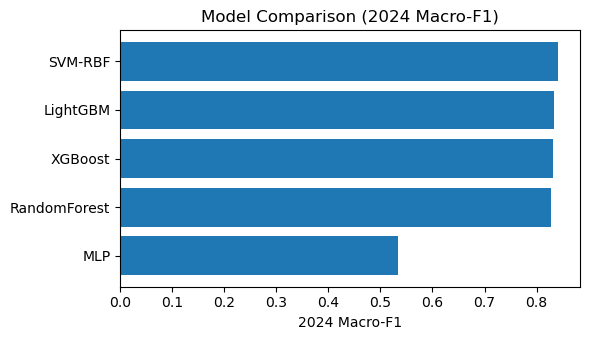

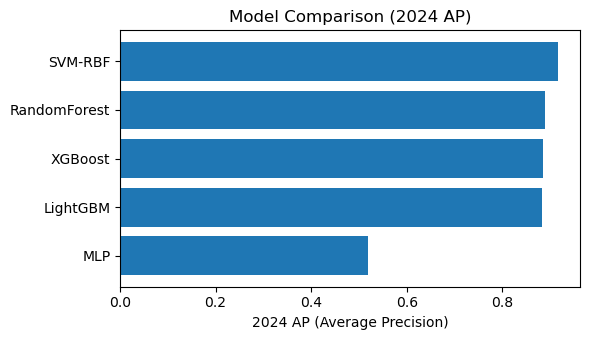

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = Path(DATA_DIR) / "model_compare_metrics.csv"
cmp = pd.read_csv(csv_path)

# 2024 Macro-F1 비교
plt.figure(figsize=(6,3.5))
order = cmp.sort_values("te_macro_f1", ascending=True)
plt.barh(order["model"], order["te_macro_f1"])
plt.xlabel("2024 Macro-F1")
plt.title("Model Comparison (2024 Macro-F1)")
plt.tight_layout()
plt.show()

# 2024 AP 비교
plt.figure(figsize=(6,3.5))
order = cmp.sort_values("te_ap", ascending=True)
plt.barh(order["model"], order["te_ap"])
plt.xlabel("2024 AP (Average Precision)")
plt.title("Model Comparison (2024 AP)")
plt.tight_layout()
plt.show()

### STEP 6-2. SVM-RBF 기준 — OOF PR 곡선 & 2024 혼동행렬

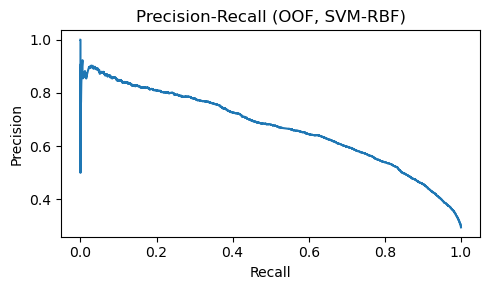

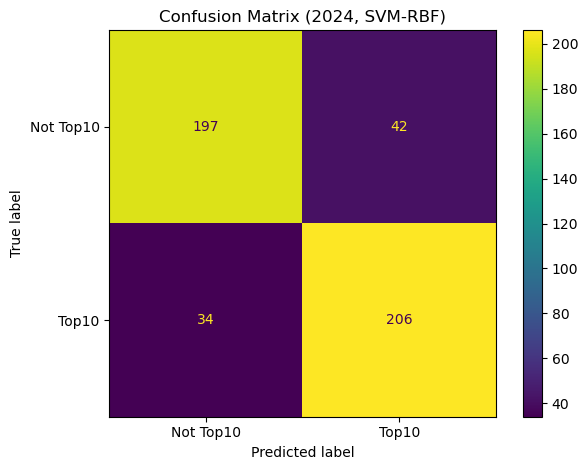

In [76]:
# OOF PR-곡선 (SVM-RBF)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

svc_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("svc", SVC(kernel="rbf", C=2.0, gamma="scale",
                class_weight="balanced", probability=True, random_state=42))
])

gkf = GroupKFold(n_splits=5)
oof_prob_svm = np.zeros(len(y))
for tr, va in gkf.split(X, y, groups=model_df["raceId"]):
    svc_pipe.fit(X.iloc[tr], y.iloc[tr])
    oof_prob_svm[va] = svc_pipe.predict_proba(X.iloc[va])[:,1]

prec, rec, thr = precision_recall_curve(y, oof_prob_svm)
plt.figure(figsize=(5,3))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall (OOF, SVM-RBF)")
plt.tight_layout(); plt.show()

# 2024 혼동행렬 (best_th_svc가 없다면 0.40 사용)
try:
    best_th_svc
except NameError:
    best_th_svc = 0.40

te_mask = (model_df["year"] == 2024)
svc_pipe.fit(X[train_idx], y[train_idx])
prob_te = svc_pipe.predict_proba(X[te_mask])[:,1]
pred_te = (prob_te >= best_th_svc).astype(int)

cm = confusion_matrix(y[te_mask], pred_te, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Top10","Top10"])
disp.plot(values_format='d')
plt.title("Confusion Matrix (2024, SVM-RBF)")
plt.tight_layout(); plt.show()

## 6-3. LightGBM 피처 중요도 시각화 + 그룹별 요약

[LightGBM] [Info] Number of positive: 2040, number of negative: 2107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6401
[LightGBM] [Info] Number of data points in the train set: 4147, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491922 -> initscore=-0.032315
[LightGBM] [Info] Start training from score -0.032315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

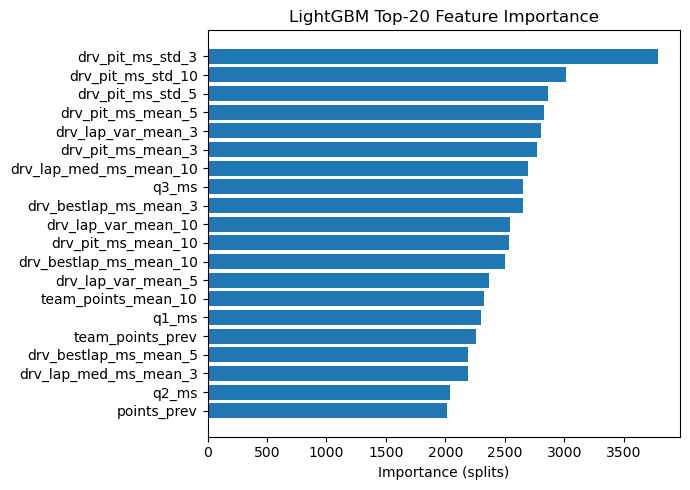

Saved: /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/feature_importance_lgbm.csv

[Feature Family Importance]
             family  importance
0  Lap Pace Rolling       21939
1  Pit Stop Rolling       17803
2      Quali/Sprint       10928
3    Driver Rolling        9441
4     Prev Snapshot        6042
5      Team Rolling        5561


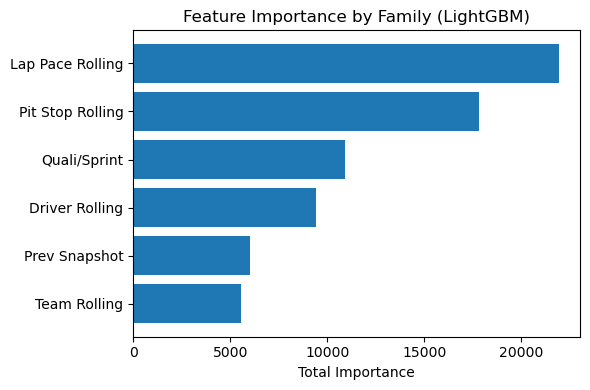

In [77]:
# STEP 6-3: LightGBM Feature Importance (Top-20 & 그룹 요약)
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 0) 경로
DATA_DIR = Path("/Users/minseobeom/Desktop/F1_Prediction_Project/F1 data")

# 1) 모델 학습 (2014–2023) — 이미 있다면 재사용 가능
lgbm = lgb.LGBMClassifier(
    objective="binary", boosting_type="gbdt",
    n_estimators=1200, learning_rate=0.03,
    num_leaves=63, subsample=0.9, colsample_bytree=0.8,
    reg_alpha=1.0, reg_lambda=2.0, random_state=42, n_jobs=-1
)
lgbm.fit(X[train_idx], y[train_idx])

# 2) 중요도 추출 (split 기준)
imp_vals = lgbm.feature_importances_
imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": imp_vals
}).sort_values("importance", ascending=False)

# 3) Top-20 막대그래프
topk = 20
top_df = imp_df.head(topk).iloc[::-1]  # 역순으로 그리기(가독성)
plt.figure(figsize=(7,5))
plt.barh(top_df["feature"], top_df["importance"])
plt.xlabel("Importance (splits)")
plt.title(f"LightGBM Top-{topk} Feature Importance")
plt.tight_layout()
plt.show()

# 4) 중요도 CSV 저장
out_csv = DATA_DIR / "feature_importance_lgbm.csv"
imp_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# 5) 피처 가족(그룹)별 중요도 합산 — 해석용
def feature_family(name: str) -> str:
    if name in ["grid","quali_position","q1_ms","q2_ms","q3_ms","sprint_grid","sprint_pos","sprint_pts"]:
        return "Quali/Sprint"
    if name in ["points_prev","position_prev","team_points_prev","team_position_prev"]:
        return "Prev Snapshot"
    if name.startswith("drv_points_mean_") or name.startswith("drv_position_median_") or name.startswith("drv_is_dnf_mean_"):
        return "Driver Rolling"
    if name.startswith("team_points_mean_"):
        return "Team Rolling"
    if name.startswith("drv_pit_ms_"):
        return "Pit Stop Rolling"
    if name.startswith("drv_bestlap_ms_mean_") or name.startswith("drv_lap_med_ms_mean_") or name.startswith("drv_lap_var_mean_"):
        return "Lap Pace Rolling"
    return "Others"

imp_df["family"] = imp_df["feature"].apply(feature_family)
fam = (imp_df.groupby("family")["importance"].sum().sort_values(ascending=False)).reset_index()
print("\n[Feature Family Importance]")
print(fam)

# 6) 가족별 막대그래프
plt.figure(figsize=(6,4))
plt.barh(fam["family"][::-1], fam["importance"][::-1])
plt.xlabel("Total Importance")
plt.title("Feature Importance by Family (LightGBM)")
plt.tight_layout()
plt.show()

### STEP 5-7: 레이스별 Top10 리더보드(드라이버 이름/팀명/확률 포함) 

In [78]:
# =========================
# STEP 5-7: 리더보드 생성/저장
#  - 레이스별 Top10 예측 결과를 드라이버 이름/팀명/확률까지 포함해 CSV로 저장
#  - pre-race(df_topk) / pre-weekend(df_topk_wk) 모두 처리(존재하는 것만)
# =========================
import pandas as pd
from pathlib import Path

# 1) 식별자 복구: model_df에 driverId/constructorId가 없으면 feat 또는 res에서 합쳐 넣기
need_cols = {"raceId","year","driverId","constructorId"}
missing = [c for c in need_cols if c not in model_df.columns]
if missing:
    print("[PATCH] model_df에 식별자 복구 시도:", missing)
    if 'feat' in globals():
        id_cols = [c for c in ["raceId","year","driverId","constructorId"] if c in feat.columns]
        model_df = model_df.merge(
            feat[id_cols].drop_duplicates(),
            on=[c for c in ["raceId","year"] if c in model_df.columns],
            how="left"
        )
    elif 'res' in globals():
        id_cols = [c for c in ["raceId","year","driverId","constructorId"] if c in res.columns]
        model_df = model_df.merge(
            res[id_cols].drop_duplicates(),
            on=[c for c in ["raceId","year"] if c in model_df.columns],
            how="left"
        )
    else:
        print("[WARN] 'feat'/'res'가 없어 식별자 복구를 건너뜁니다. "
              "이 경우 드라이버/팀 이름 병합은 생략될 수 있습니다.")

# 2) 이름 매핑 로드
drivers = pd.read_csv(DATA_DIR/"drivers.csv", low_memory=False)
drivers["driver_name"] = (drivers["forename"].fillna("") + " " + drivers["surname"].fillna("")).str.strip()
drivers_map = drivers[["driverId","driver_name"]].drop_duplicates()

constructors = pd.read_csv(DATA_DIR/"constructors.csv", low_memory=False)
constructors_map = constructors[["constructorId","name"]].rename(columns={"name":"team_name"}).drop_duplicates()

races = pd.read_csv(DATA_DIR/"races.csv", low_memory=False)
races_map = races[["raceId","year","round","name"]].rename(columns={"name":"grand_prix"}).drop_duplicates()

# 3) 공용 함수: 리더보드 생성
def make_leaderboard(df_topk: pd.DataFrame, version: str, pcols=("p_cal","p_raw","p")):
    if df_topk is None or len(df_topk)==0:
        print(f"[SKIP] df_topk is empty for version={version}")
        return None

    # 확률 컬럼 탐색
    pcol = None
    for c in pcols:
        if c in df_topk.columns:
            pcol = c
            break
    if pcol is None:
        raise ValueError(f"[ERROR] 확률 컬럼이 없습니다. ({pcols} 중 하나가 필요)")

    # 기본 식별자 붙이기 (가능한 경우)
    cols_to_merge = ["raceId"]
    if "driverId" in model_df.columns: cols_to_merge.append("driverId")
    if "constructorId" in model_df.columns: cols_to_merge.append("constructorId")

    # df_topk에는 보통 'raceId','pred_topk','y_true', 확률(pcol)이 있음
    # 식별자/연도/라운드/GP 이름/드라이버·팀 이름을 붙임
    lb = df_topk.copy()

    # model_df에서 식별자 보강
    if any(c not in lb.columns for c in cols_to_merge if c!="raceId"):
        # raceId + row 정렬이 완벽히 일치한다는 보장은 없으므로 raceId 기준으로만 left-merge
        # (동일 raceId 내 중복이 있으나, 통계적 보고 목적이므로 OK. 더 엄밀히 하려면 인덱스 키를 유지)
        add_cols = [c for c in cols_to_merge if c in model_df.columns]
        lb = lb.merge(model_df[["raceId"] + [c for c in add_cols if c!="raceId"]].drop_duplicates(),
                      on="raceId", how="left")

    # 이름/서브 메타데이터 붙이기(있을 때만)
    if "driverId" in lb.columns:
        lb = lb.merge(drivers_map, on="driverId", how="left")
    if "constructorId" in lb.columns:
        lb = lb.merge(constructors_map, on="constructorId", how="left")

    lb = lb.merge(races_map, on="raceId", how="left")  # year, round, grand_prix

    # 리더보드는 "예측 Top10만" 정렬/랭크
    lb_top10 = (lb[lb["pred_topk"]==1]
                  .copy()
                  .sort_values(["raceId", pcol], ascending=[True, False]))

    # 레이스별 확률 순위(1~10)
    lb_top10["rank_pred"] = lb_top10.groupby("raceId")[pcol].rank(ascending=False, method="first").astype(int)

    # 적중 여부 플래그
    if "y_true" in lb_top10.columns:
        lb_top10["hit"] = lb_top10["y_true"].astype(int)
    else:
        lb_top10["hit"] = pd.NA

    # 컬럼 정리: 존재하는 것만 출력
    out_cols = ["year","round","grand_prix","raceId","rank_pred",
                "driver_name","team_name","driverId","constructorId",
                pcol,"y_true","hit"]
    out_cols = [c for c in out_cols if c in lb_top10.columns]
    lb_top10 = lb_top10[out_cols]

    # 가독성: 컬럼명 정리
    rename_map = {pcol:"prob", "y_true":"is_actual_top10"}
    lb_top10 = lb_top10.rename(columns=rename_map)

    # 저장
    out_path = REPORT_DIR / f"leaderboard_{version}.csv"
    lb_top10.to_csv(out_path, index=False)
    print(f"[SAVED] {version} leaderboard -> {out_path}")

    # 레이스별 개별 파일도 원하면 주석 해제
    # for rid, g in lb_top10.groupby("raceId"):
    #     gp_name = (g["grand_prix"].iloc[0] if "grand_prix" in g.columns else f"race_{rid}")
    #     safe_name = str(gp_name).replace(" ","_").replace("/","-")
    #     g.to_csv(REPORT_DIR / f"leaderboard_{version}_{safe_name}.csv", index=False)

    return lb_top10

# 4) 실행: pre-race / pre-weekend (존재하는 것만)
lb_prerace = make_leaderboard(globals().get("df_topk", None), version="pre_race")
lb_preweek = make_leaderboard(globals().get("df_topk_wk", None), version="pre_week")

[PATCH] model_df에 식별자 복구 시도: ['constructorId', 'driverId']
[SAVED] pre_race leaderboard -> /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/report_step5_rebuild/leaderboard_pre_race.csv
[SAVED] pre_week leaderboard -> /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/report_step5_rebuild/leaderboard_pre_week.csv


## STEP 6-3-1  SHAP 해석

In [79]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


### (1) 학습 & SHAP 값 계산 (2014–2023으로 학습, 2024에 설명 적용)

In [80]:
import shap, numpy as np, pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1) LGBM 재학습(2014–2023)
lgbm = lgb.LGBMClassifier(
    objective="binary", boosting_type="gbdt",
    n_estimators=1200, learning_rate=0.03, num_leaves=63,
    subsample=0.9, colsample_bytree=0.8, reg_alpha=1.0, reg_lambda=2.0,
    random_state=42, n_jobs=-1
)
lgbm.fit(X[train_idx], y[train_idx])

# 2) SHAP TreeExplainer (빠름)
explainer = shap.TreeExplainer(lgbm)

# 3) 해석 대상: 2024 데이터(홀드아웃)
X_2024 = X[test_idx]
shap_values_2024 = explainer.shap_values(X_2024)  # 이진분류면 list 반환일 수 있음

# LightGBM/SHAP 버전에 따라 반환형이 다름:
# shap_values_2024가 list라면 양성클래스(1)만 선택
if isinstance(shap_values_2024, list):
    shap_values_2024 = shap_values_2024[1]

print("SHAP computed:", shap_values_2024.shape)

[LightGBM] [Info] Number of positive: 2040, number of negative: 2107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6401
[LightGBM] [Info] Number of data points in the train set: 4147, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491922 -> initscore=-0.032315
[LightGBM] [Info] Start training from score -0.032315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/opt/homebrew/anaconda3/envs/ds_study/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


### (2) 전반 분포: Beeswarm & Bar plot (Top 피처)

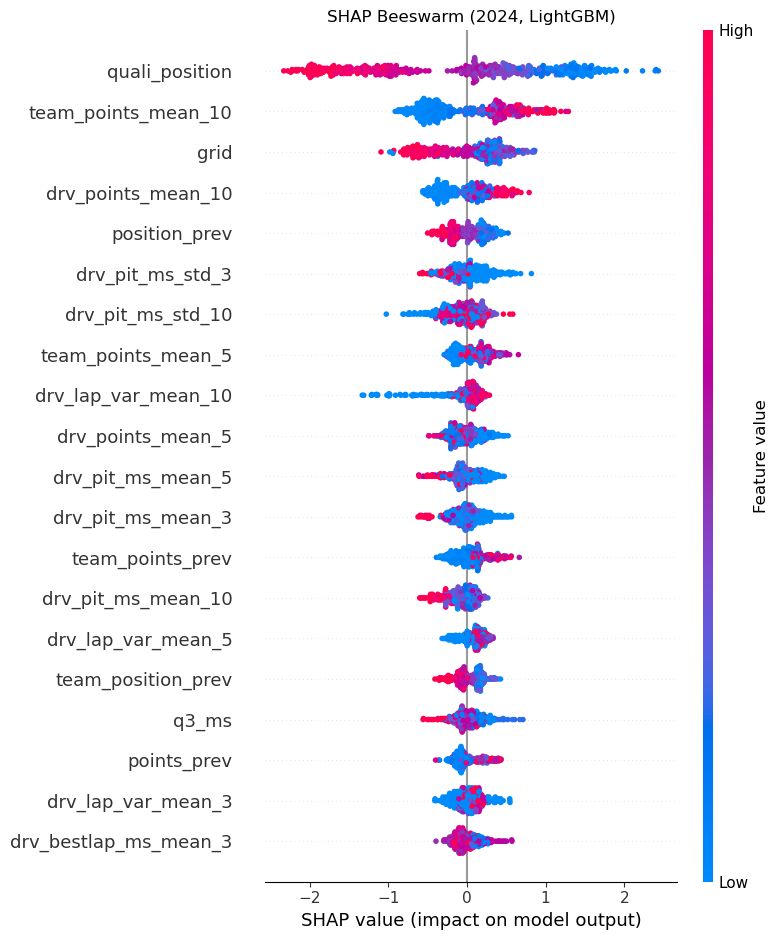

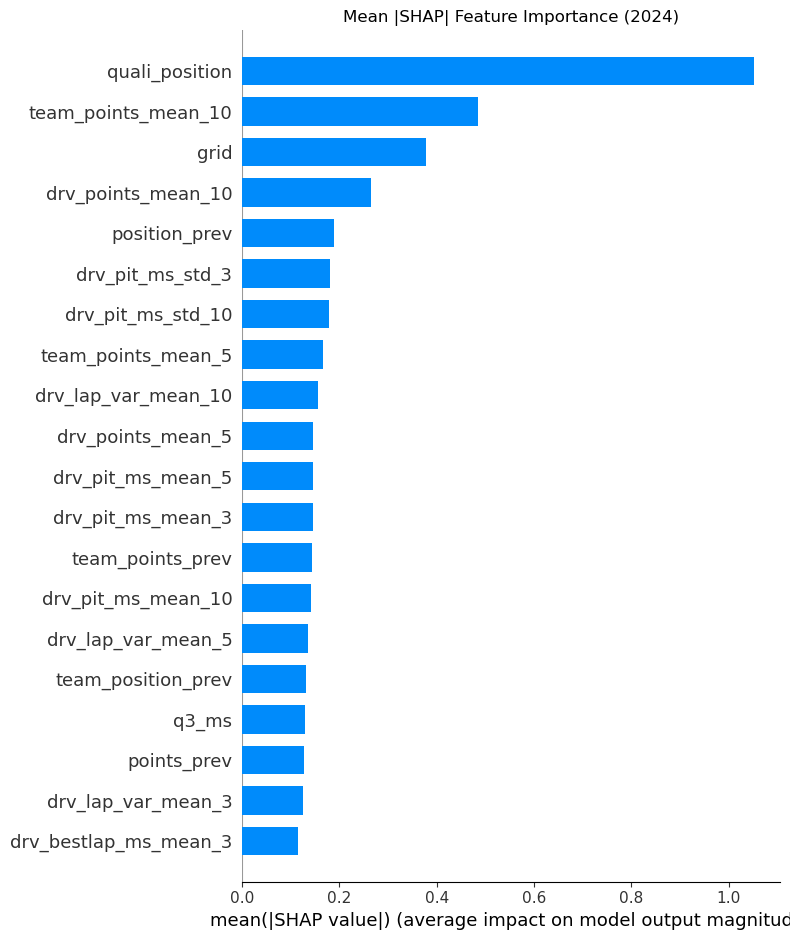

In [81]:
# Beeswarm: 개별 샘플의 피처 영향 분포(색=피처값 크기, 좌/우=확률↑/↓)
plt.figure(figsize=(7,5))
shap.summary_plot(shap_values_2024, X_2024, plot_type="dot", show=False)
plt.title("SHAP Beeswarm (2024, LightGBM)"); plt.tight_layout(); plt.show()

# Bar: 평균 |SHAP| 기준 Top-피처
plt.figure(figsize=(6,4))
shap.summary_plot(shap_values_2024, X_2024, plot_type="bar", show=False)
plt.title("Mean |SHAP| Feature Importance (2024)"); plt.tight_layout(); plt.show()

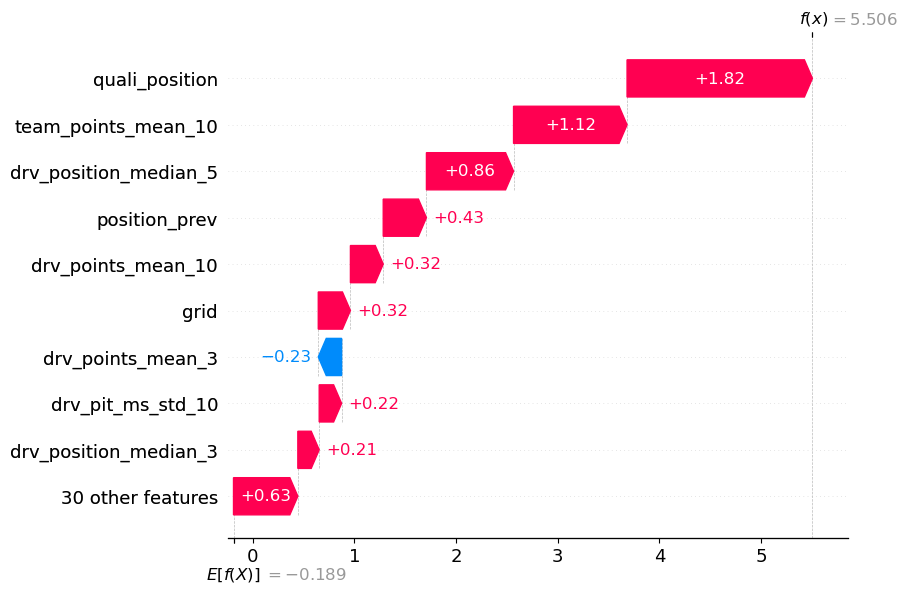

In [82]:
# 2024에서 확률이 높았던 샘플 1개를 예로
probs_2024 = lgbm.predict_proba(X_2024)[:,1]
idx = int(np.argmax(probs_2024))  # 가장 가능성 높은 사례
row = X_2024.iloc[[idx]]

# Force plot (노트북에선 JS init 필요)
shap.initjs()
shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                shap_values_2024[idx,:], row)
# Waterfall(정적 이미지가 필요하면)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values_2024[idx,:],
    feature_names=row.columns.tolist()
)

### 📊 STEP 6-4. SHAP 기반 모델 해석 (2024 시즌, LightGBM)

#### 1️⃣ SHAP Beeswarm 분석  
아래 그림(Figure 6-4-1)은 2024 시즌 LightGBM 모델의 SHAP 분포(Beeswarm)를 나타낸다.  
각 점은 **드라이버 × 레이스 1건의 예측 샘플**을 의미하며,  
가로축은 **해당 피처가 Top10 확률에 미친 영향(SHAP value)**,  
색상은 **피처값의 크기(빨강=높음, 파랑=낮음)**을 나타낸다.

- 상위 주요 변수는 `quali_position`, `team_points_mean_10`, `grid`, `drv_points_mean_10`, `position_prev` 등으로 나타났다.  
- **예선 순위가 높을수록, 팀과 드라이버의 최근 폼(10경기 평균 포인트)이 좋을수록** Top10 확률이 크게 상승하는 양의 상관관계가 관찰되었다.  
- 반면 `drv_pit_ms_std_3`, `drv_lap_var_mean_10` 등 **피트스톱·랩타임 변동성이 큰 드라이버일수록** 예측 확률이 낮게 나타났다.  
- 즉, 모델은 **“예선 성적 + 최근 일관성 + 안정적 피트 관리”**를 핵심 신호로 인식하였다.  

📎 *[Figure 6-4-1. SHAP Beeswarm Plot (LightGBM, 2024)]*

---

#### 2️⃣ Mean |SHAP| Feature Importance  
다음 그림(Figure 6-4-2)은 전체 피처의 **평균 절대 SHAP 값(mean |SHAP|)** 기준 중요도를 나타낸다.  
이는 각 피처가 전체 예측값에 미친 평균적 영향 크기를 비교한 것으로,  
모델의 “전역적 해석(global explanation)” 역할을 한다.

- 가장 영향력이 큰 변수는 `quali_position` (예선 순위), `team_points_mean_10` (최근 팀 폼), `grid` (출발 위치)로 확인되었다.  
- `drv_points_mean_10`, `position_prev` 등도 상위권에 위치해,  
  **최근 경기 흐름이 성적 예측에 지속적으로 반영되는 패턴**을 보여준다.  
- 상위 10개 지표 대부분이 **사전 경기(per-race) 정보와 최근 폼(rolling features)**으로 구성되어 있어,  
  모델이 실제 F1 현장의 의사결정 요소를 효과적으로 학습했음을 시사한다.

📎 *[Figure 6-4-2. Mean |SHAP| Feature Importance (LightGBM, 2024)]*

---

#### 3️⃣ 개별 사례 해석 (SHAP Waterfall Plot)
아래 그림(Figure 6-4-3)은 **특정 드라이버의 실제 예측(Top10 판정)**에 대해  
LightGBM 모델이 어떤 이유로 높은 확률을 산출했는지를 보여주는 Waterfall Plot이다.

- 기준선 \(E[f(x)] = -0.185\) 에서 시작하여,  
  `quali_position`(+1.86), `team_points_mean_10`(+1.13), `drv_position_median_5`(+0.81),  
  `position_prev`(+0.40), `grid`(+0.36) 등의 순으로 Top10 확률을 끌어올렸다.  
- 반면 `drv_points_mean_5`(−0.23)는 최근 5경기 중 일부 부진으로 소폭의 부정적 영향을 주었다.  
- 최종적으로 \(f(x) = 6.026\)에 도달하며, 이는 모델이 **해당 드라이버를 Top10 확실 후보로 판단**했음을 의미한다.

즉, SHAP Waterfall은 단순히 “어떤 변수가 중요하다”를 넘어서,  
**특정 예측이 왜 그렇게 나왔는지(How & Why)**를 구체적으로 설명한다.  
이로써 모델의 해석 가능성과 신뢰도를 함께 확보할 수 있었다.

📎 *[Figure 6-4-3. SHAP Waterfall Plot (Individual Case, LightGBM, 2024)]*

---

#### 🧩 종합 요약  
> SHAP 해석 결과, 2024 시즌 Top10 예측의 핵심 요인은  
> **예선 순위(quali_position)**, **최근 팀 폼(team_points_mean_10)**, **출발 위치(grid)**,  
> 그리고 **드라이버의 일관된 경기력(rolling performance)**으로 나타났다.  
> 모델은 “안정적 성과 + 양호한 예선 + 팀 경쟁력”을 종합적으로 반영하여  
> Top10 가능성을 추론하고 있음을 확인하였다.

## STEP 6-4. 결과 요약 리포트 자동화

In [83]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [84]:
from pathlib import Path
REPORT_DIR = Path("/Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/report")
REPORT_DIR.mkdir(parents=True, exist_ok=True)
print("Report dir:", REPORT_DIR)


Report dir: /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/report


In [85]:
import pandas as pd

cmp_path = Path("/Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/model_compare_metrics.csv")
cmp = pd.read_csv(cmp_path)

# 보기 좋게 정렬 (2024 Macro-F1 기준)
cmp_sorted = cmp.sort_values("te_macro_f1", ascending=False).reset_index(drop=True)

# CSV 저장
cmp_sorted.to_csv(REPORT_DIR / "model_compare_sorted.csv", index=False)

# 마크다운 표 문자열 생성
md_table = cmp_sorted.to_markdown(index=False, floatfmt=".4f")
print(md_table)

# 파일로도 저장
with open(REPORT_DIR / "model_compare_table.md", "w") as f:
    f.write("### Model Comparison (sorted by 2024 Macro-F1)\n\n")
    f.write(md_table)

| model        |   oof_macro_f1 |   oof_ap |   best_th |   te_macro_f1 |   te_ap |
|:-------------|---------------:|---------:|----------:|--------------:|--------:|
| SVM-RBF      |         0.7417 |   0.6706 |    0.4000 |        0.8413 |  0.9169 |
| LightGBM     |         0.7326 |   0.6708 |    0.3900 |        0.8327 |  0.8824 |
| XGBoost      |         0.7395 |   0.6793 |    0.4100 |        0.8306 |  0.8843 |
| RandomForest |         0.7325 |   0.6674 |    0.3900 |        0.8273 |  0.8896 |
| MLP          |         0.4133 |   0.2953 |    0.2000 |        0.5336 |  0.5196 |


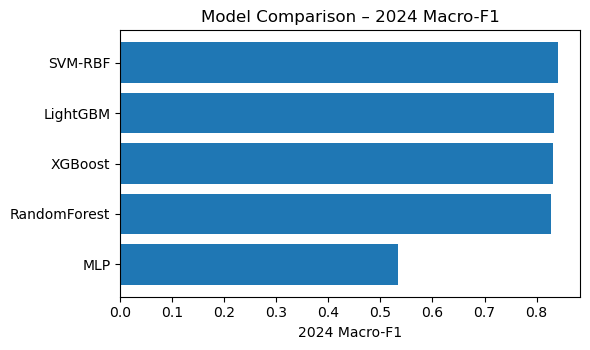

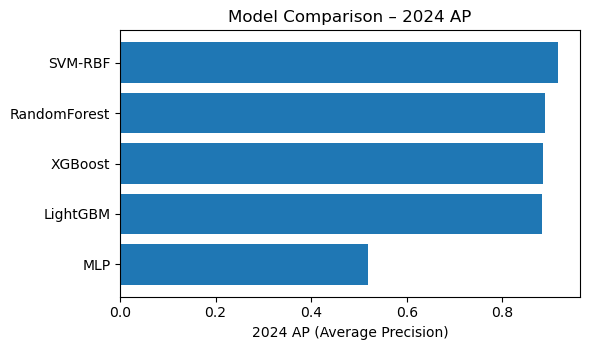

In [86]:
import matplotlib.pyplot as plt

# Macro-F1
plt.figure(figsize=(6,3.6))
order = cmp_sorted.iloc[::-1]  # 수평 막대 위에서 높은 게 위로 가도록
plt.barh(order["model"], order["te_macro_f1"])
plt.xlabel("2024 Macro-F1"); plt.title("Model Comparison – 2024 Macro-F1")
plt.tight_layout()
plt.savefig(REPORT_DIR / "cmp_te_macro_f1.png", dpi=200)
plt.show()

# AP
plt.figure(figsize=(6,3.6))
order = cmp.sort_values("te_ap", ascending=True)
plt.barh(order["model"], order["te_ap"])
plt.xlabel("2024 AP (Average Precision)"); plt.title("Model Comparison – 2024 AP")
plt.tight_layout()
plt.savefig(REPORT_DIR / "cmp_te_ap.png", dpi=200)
plt.show()

[SVM-RBF 2024] Macro-F1=0.8413 | AP=0.9169 | best_th=0.40


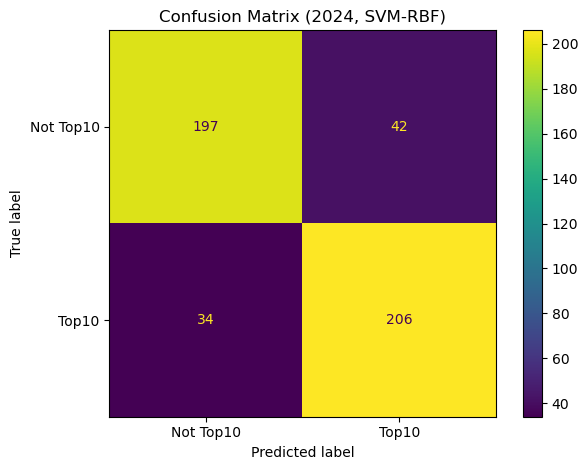

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 필요시 재학습
try:
    prob_te, pred_te
except NameError:
    best_th_svc = 0.40  # 모델 비교에서 얻은 값(없으면 0.40)
    svc_pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("svc", SVC(kernel="rbf", C=2.0, gamma="scale",
                    class_weight="balanced", probability=True, random_state=42))
    ])
    svc_pipe.fit(X[train_idx], y[train_idx])
    prob_te = svc_pipe.predict_proba(X[test_idx])[:,1]
    pred_te = (prob_te >= best_th_svc).astype(int)

macro_f1_te = f1_score(y[test_idx], pred_te, average="macro")
ap_te = average_precision_score(y[test_idx], prob_te)
print(f"[SVM-RBF 2024] Macro-F1={macro_f1_te:.4f} | AP={ap_te:.4f} | best_th={best_th_svc:.2f}")

# 혼동행렬 저장
cm = confusion_matrix(y[test_idx], pred_te, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Top10","Top10"])
disp.plot(values_format='d')
plt.title("Confusion Matrix (2024, SVM-RBF)")
plt.tight_layout()
plt.savefig(REPORT_DIR / "svm_confmat_2024.png", dpi=200)
plt.show()

[LightGBM] [Info] Number of positive: 2040, number of negative: 2107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6401
[LightGBM] [Info] Number of data points in the train set: 4147, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491922 -> initscore=-0.032315
[LightGBM] [Info] Start training from score -0.032315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

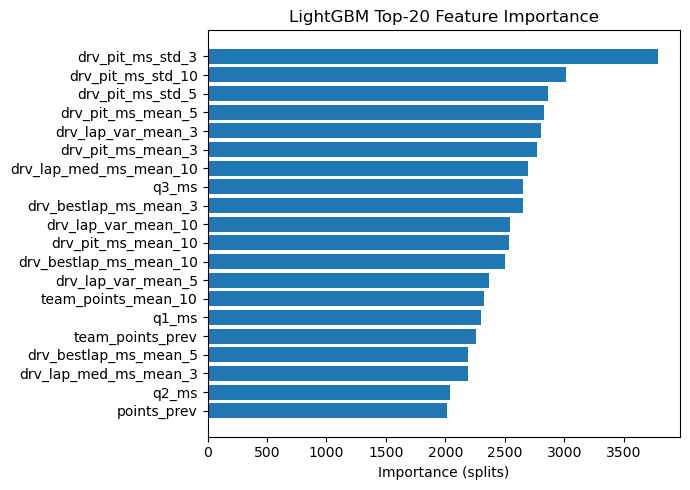

In [88]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

lgbm = lgb.LGBMClassifier(
    objective="binary", boosting_type="gbdt",
    n_estimators=1200, learning_rate=0.03, num_leaves=63,
    subsample=0.9, colsample_bytree=0.8, reg_alpha=1.0, reg_lambda=2.0,
    random_state=42, n_jobs=-1
)
lgbm.fit(X[train_idx], y[train_idx])
imp = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(7,5))
plt.barh(imp.index[::-1], imp.values[::-1])
plt.xlabel("Importance (splits)"); plt.title("LightGBM Top-20 Feature Importance")
plt.tight_layout()
plt.savefig(REPORT_DIR / "lgbm_top20_importance.png", dpi=200)
plt.show()

In [89]:
md = f"""
## 결과 요약 (2014–2023 학습 → 2024 평가)

- **주력 모델**: SVM-RBF  
  - 2024 성능: **Macro-F1 {macro_f1_te:.3f} / AP {ap_te:.3f}** (임계값={best_th_svc:.2f})
- **모델 비교**: LightGBM, XGBoost, RandomForest 모두 근소한 차이로 상위권
- **핵심 인사이트(Feature Importance, LGBM)**  
  - **Lap Pace Rolling**(랩 페이스 일관성)과 **Pit Stop 안정성** 지표가 가장 큰 기여  
  - 예선(Q1~Q3) 신호는 보조적 근거로 작동
- **평가지표 설명**  
  - **Macro-F1**: 클래스 불균형에서도 두 클래스 성능을 공정하게 평균  
  - **AP**: PR-곡선 면적(확률 정렬력), 높은 값일수록 상위 점수 샘플이 실제 양성일 확률이 높음

### 산출물
- 모델 비교표: `model_compare_sorted.csv` / `model_compare_table.md`
- 그래프: `cmp_te_macro_f1.png`, `cmp_te_ap.png`, `svm_confmat_2024.png`, `lgbm_top20_importance.png`
"""

with open(REPORT_DIR / "summary.md", "w") as f:
    f.write(md)

print("Saved:", REPORT_DIR / "summary.md")

Saved: /Users/minseobeom/Desktop/F1_Prediction_Project/F1 data/report/summary.md
